In [2]:
# Import necessary libraries
import os
import re
import glob as glob
import string
import numpy as np
import pandas as pd
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import textstat
import statsmodels.api as sm
from datetime import datetime
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.mixture import GaussianMixture
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')  

# Load spaCy model for advanced NLP processing
nlp = spacy.load('en_core_web_sm')

# Print library versions for reproducibility
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"nltk version: {nltk.__version__}")
print(f"matplotlib version: {plt.matplotlib.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"spacy version: {spacy.__version__}")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/noemilucchi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noemilucchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/noemilucchi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/noemilucchi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/noemilucchi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/noemilucchi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


pandas version: 2.2.3
numpy version: 2.0.0
nltk version: 3.9.1
matplotlib version: 3.10.0
seaborn version: 0.12.1
spacy version: 3.8.2


# Research Question: Does Presidential Rethoric reflect economic conditions?

In order to answer this question, we combined different analytical approaches to gain insights about the evolution 
of presidential speeches over time and explore differences across parties and specific historical moments, 
with special attention to economic conditions.

## Implemented analytical tools:
- **Exploratory Analysis**: Using K-means clustering and PCA visualization to identify distinct patterns in presidential language across different historical periods, complemented by word clouds to visualize key terminology.
- **Sentiment Analysis**: To study the evolution of emotional tone over time and examine alignment between presidential rhetoric and actual economic conditions.
- **Economic Correlation**: Comparing presidential sentiment with a composite economic index created from  macroeconomic indicators to assess alignment between rhetoric and economic reality.
- **Readability Index**: To understand if speech complexity varies depending on topic, economic conditions, or historical context.
- **Classification Models**: Testing whether speech content alone (from 1789) provides accurate classification, or if including macroeconomic indicators (available only from 1950) significantly improves model performance.

## Data loading and pre-processing
We began by aggregating individually **scraped presidential speech** datasets into a unified corpus. Our preprocessing included:
- Extracting temporal information (day, month, year) from the 'Title' column
- Creating a decade classification
- Text preprocessing to clean speech content
- Merging speech data with economic indicators

### For **macroeconomic data**, we utilized the following indicators from the Federal Reserve Economic Data (FRED) repository:
- **Real GDP** - Annual measurements to track economic growth rates
- **Unemployment Rate** - Monthly measurements of labor market performance
- **Consumer Price Index** - Monthly measurements of price stability and inflation

### For **Consumer Sentiment**, we incorporated data from a study conducted by the University of Michigan (retrieved from FRED).

Given that speeches span from 1789 to 2025, while comprehensive economic indicators are only available from 1950 onward, 
we created two distinct analytical datasets:
- **historical_df**: Contains all available speeches (1789-2025) for linguistic analysis and classification based solely on speech content
- **economic_df**: A more limited dataset (1950 onward) that combines speech data with macroeconomic indicators and consumer sentiment

This dual approach allowed us to investigate the tradeoff between sample size and feature richness while addressing 
our core research question about the relationship between presidential language, economic conditions, and public sentiment.

In [2]:
# Path to the folder with the csv for the speeches 
folder_path = "/Users/noemilucchi/Desktop/CodeTerm2/TextMining/final_paper/speech"

# List all the csv within this folder 
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Combine all the csv in a new dataframe
df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

# Drop the column with the URL
df = df.drop(columns=['URL']) 

# Regex function to extract month, day of the month and year 
date_pattern = r'([A-Za-z]+) (\d{1,2}), (\d{4})'

# Create three new columns for these information
df[['Month', 'Day', 'Year']] = df['Title'].str.extract(date_pattern)

# Remove month, day of the month, year and colon from the title 
df['Title'] = df['Title'].str.replace(date_pattern, '', regex=True).str.replace(':', '', regex=False).str.strip()

# Create the new column "Decade" 
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Decade'] = (df['Year'] // 10) * 10

# Load the economic data from FRED
df_gdp = pd.read_csv('/Users/noemilucchi/Desktop/CodeTerm2/TextMining/final_paper/speech/data/GDPCA.csv')
df_unemployment = pd.read_csv('/Users/noemilucchi/Desktop/CodeTerm2/TextMining/final_paper/speech/data/UNRATE.csv')
df_cpi = pd.read_csv('/Users/noemilucchi/Desktop/CodeTerm2/TextMining/final_paper/speech/data/CPIAUCNS.csv')

# Convert date columns to datetime format
df['Month_Num'] = pd.to_datetime(df['Month'], format='%B').dt.month
df['Year'] = df['Year'].astype(int)
df['Month_Num'] = df['Month_Num'].astype(int)
df['Day'] = df['Day'].astype(int)

df_gdp['Date'] = pd.to_datetime(df_gdp['observation_date'])
df_unemployment['Date'] = pd.to_datetime(df_unemployment['observation_date'])
df_cpi['Date'] = pd.to_datetime(df_cpi['observation_date'])

# Calculate annual inflation rate from CPI
df_cpi['Inflation_Rate'] = df_cpi['CPIAUCNS'].pct_change(12) * 100

# Calculate GDP growth rate
df_gdp['GDPCA'] = pd.to_numeric(df_gdp['GDPCA'], errors='coerce')
df_gdp['GDP_growth'] = df_gdp['GDPCA'].pct_change() * 100

# Create new year and month columns for merging
df_gdp['Year'] = df_gdp['Date'].dt.year
df_unemployment['Year'] = df_unemployment['Date'].dt.year
df_unemployment['Month_Num'] = df_unemployment['Date'].dt.month
df_cpi['Year'] = df_cpi['Date'].dt.year

# First we merge GDP data with speeches dataframe based on year
df_merged = df.merge(df_gdp[['Year', 'GDPCA', 'GDP_growth']], 
                         on='Year', 
                         how='left')

# Then we merge unemployment data based on year and month
df_merged = df_merged.merge(df_unemployment[['Year', 'Month_Num', 'UNRATE']], 
                             on=['Year', 'Month_Num'], 
                             how='left')
# Rename UNRATE column to Unemployment_Rate
df_merged.rename(columns={'UNRATE': 'Unemployment_Rate'}, inplace=True)

# Then we merge inflation data based on year and month
df_cpi['Month_Num'] = df_cpi['Date'].dt.month
df_merged = df_merged.merge(df_cpi[['Year', 'Month_Num', 'Inflation_Rate']], 
                             on=['Year', 'Month_Num'], 
                             how='left')

# Load the dataframe with the Consumer Sentiment
df_csentiment = pd.read_csv('/Users/noemilucchi/Desktop/CodeTerm2/TextMining/final_paper/speech/data/UMCSENT.csv')

In [3]:
# Function to pre-process the speeches 

# Initialize tqdm 
tqdm.pandas()

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Get the standard English stopwords
STOP_WORDS = set(stopwords.words('english'))

# Custom stopwords 
custom_stopwords = {'transcript', 'its', 'in', 'but', 'and', 'then', 'if', 'people', 'know', 'united', 'states', 'governments', 'upon', 
                    'america', 'americans', 'nation', 'country', 'one', 'going', 'united states', 'state', 'government', 'may', 'made'}

# Update stopwords with custom ones
STOP_WORDS.update(custom_stopwords)

# Pre-processing function
def text_processing(text):
    if not isinstance(text, str):  
        return ""  

    # Convert to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words and non-alphanumeric tokens
    tokens = [token for token in tokens if token not in STOP_WORDS and token.isalnum()]
    
    # Apply lemmatization 
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return " ".join(lemmatized_tokens)

# Apply the function to the speeches column 
df_merged['Content'] = df_merged['Content'].astype(str)
df_merged['Content_cleaned'] = df_merged['Content'].progress_apply(text_processing)

  0%|          | 0/873 [00:00<?, ?it/s]

100%|██████████| 873/873 [00:17<00:00, 50.20it/s]


# Evolution of the presidential language over time

## Word Clouds by historical periods 

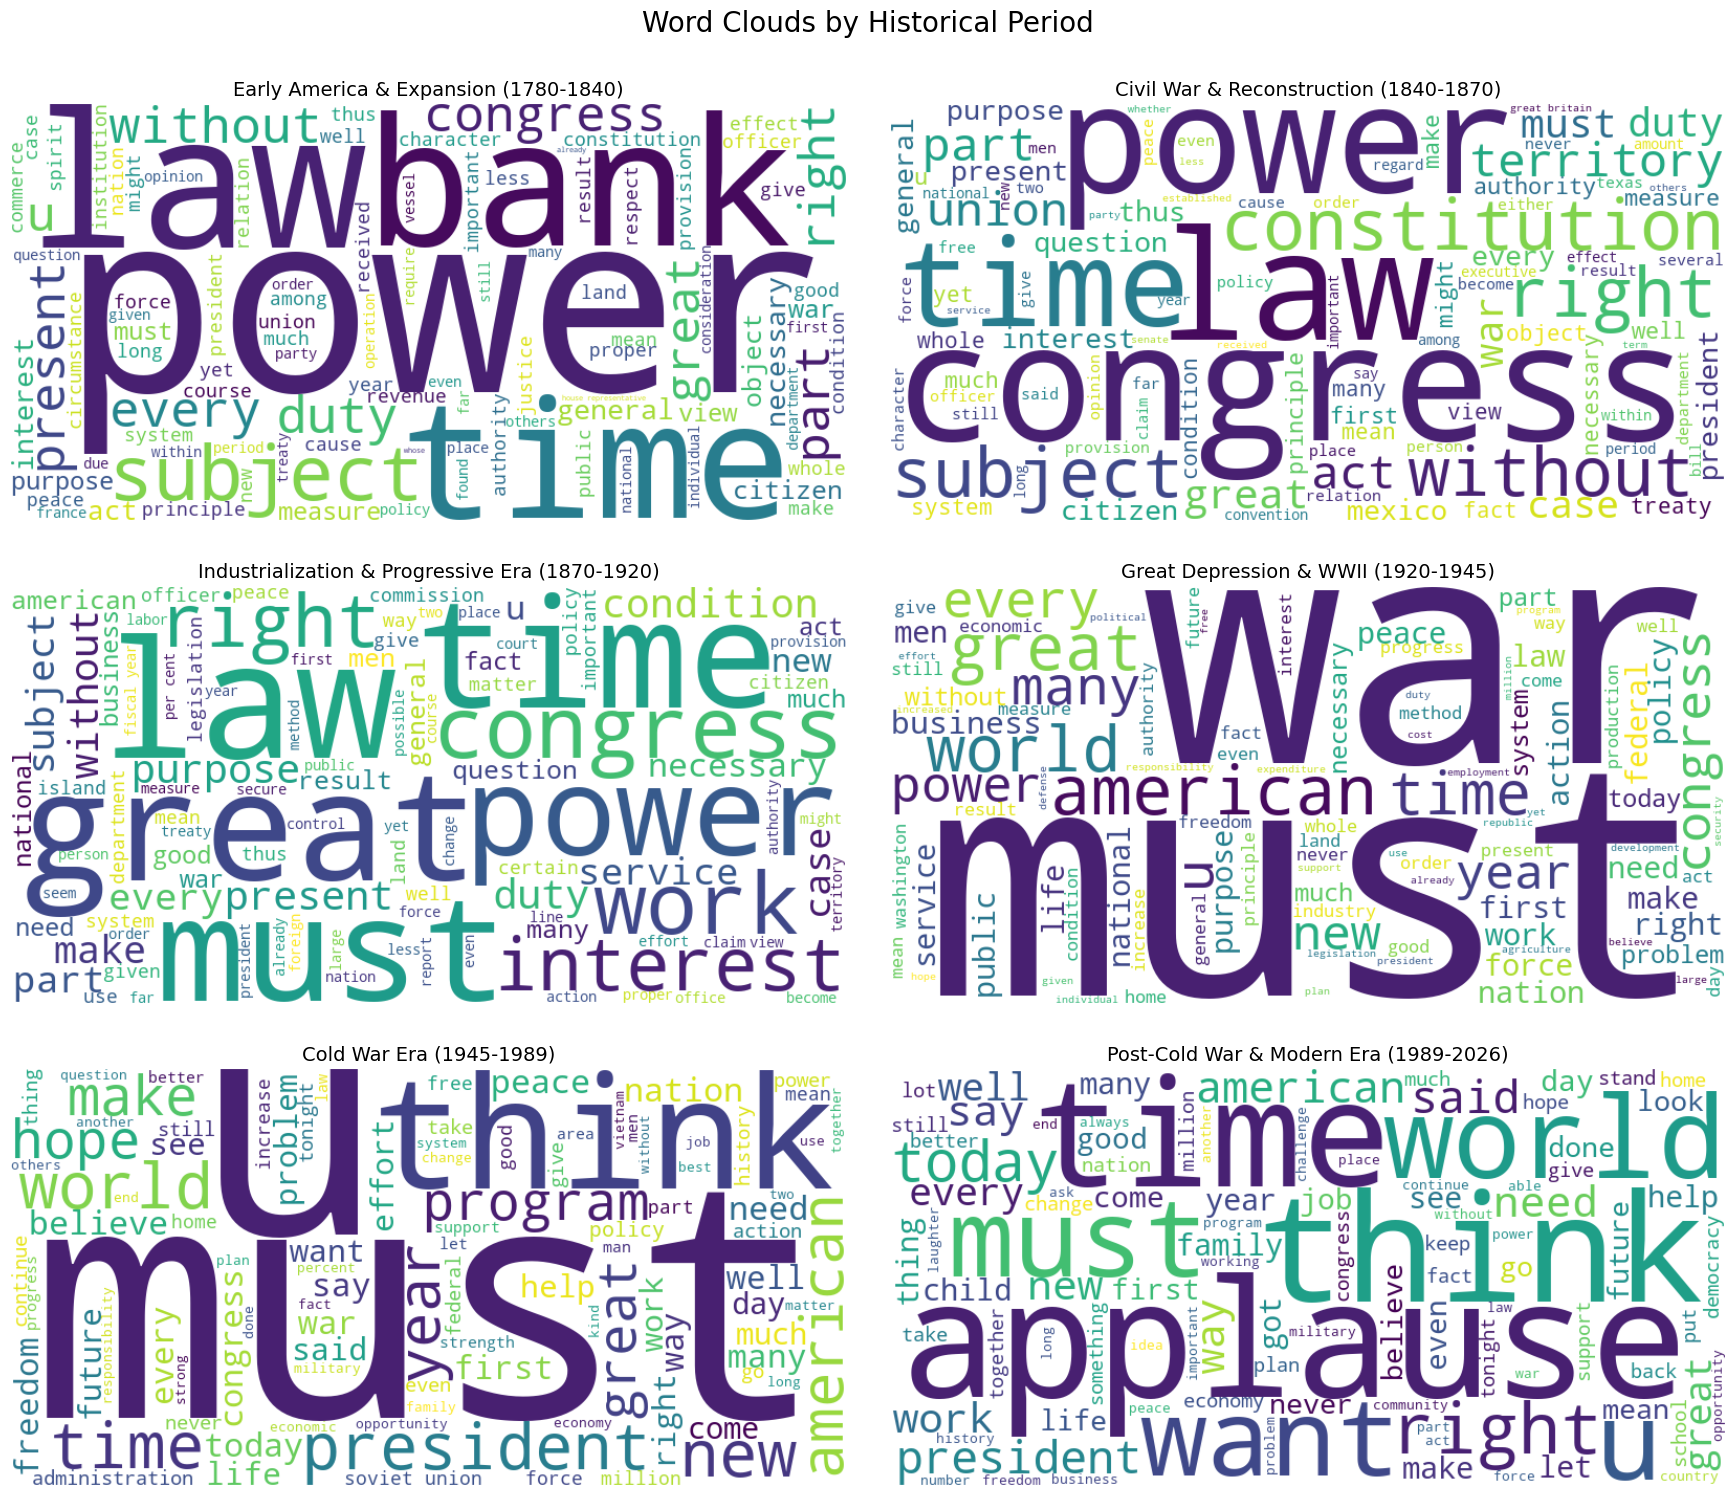

In [ ]:
# Define historical periods and the respective decades 
historical_periods = {
    "Early America & Expansion" : (1780, 1840),           # Foundation of the Republic and territorial expansion
    "Civil War & Reconstruction" : (1840, 1870),          # Civil war and Reconstruction
    "Industrialization & Progressive Era": (1870, 1920),  # Industrilization, Gilded Age e and progressive reforms
    "Great Depression & WWII" : (1920, 1945),             # '29 crisis, New Deal, WWII
    "Cold War Era" : (1945, 1989),                        # Cold War, Vietnam War and Civil rights 
    "Post-Cold War & Modern Era" : (1989, 2026)}          # End cold war, Globalization and 11/9

# Create 'Decade' column
df_merged["Decade"] = (df_merged["Year"] // 10) * 10

# Function to assign the historical period 
def assign_historical_period(year):
    for period, (start, end) in historical_periods.items():
        if start <= year < end:
            return period
    return "Unknown"

# Create the column for the historical period 
df_merged["Historical_Period"] = df_merged["Year"].apply(assign_historical_period)

# Create df for each period 
historical_dataframes = {period: df_merged[df_merged["Historical_Period"] == period] for period in historical_periods.keys()}

# Order periods chronologically 
period_list = list(historical_periods.keys())

# Create word clouds 
num_rows = (len(period_list) + 1) // 2
fig, axes = plt.subplots(num_rows, 2, figsize=(18, 5 * num_rows))

for i, period_name in enumerate(period_list):
    row_idx, col_idx = divmod(i, 2)  # Calcolo della posizione nella griglia
    period_df = historical_dataframes[period_name]
    ax = axes[row_idx, col_idx]

    if 'Content_cleaned' in period_df.columns and not period_df.empty:
        text = " ".join(period_df['Content_cleaned'])
        start_decade, end_decade = historical_periods[period_name]

        wordcloud = WordCloud(
            width=800, 
            height=400, 
            background_color='white',
            max_words=100,
            contour_width=1,
            contour_color='steelblue',
            random_state=42).generate(text)
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"{period_name} ({start_decade}-{end_decade})", fontsize=14)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout(pad=3)
plt.suptitle("Word Clouds by Historical Period", fontsize=20, y=1.02)
plt.show()

Looking at these word clouds divided by historical periods, we can already identify a clear evolution in presidential rhetoric:

- **Early America & Expansion (1780-1840)**: Dominated by institutional terms like "law," "bank," "power," and "congress," reflecting the nation-building focus and establishment of governmental frameworks.

- **Civil War & Reconstruction (1840-1870)**: "Power," "law," and "congress" remain prominent, with "territory" and "duty" emerging as significant, highlighting the territorial disputes and moral imperatives of this turbulent period.

- **Industrialization & Progressive Era (1870-1920)**: "Great," "law," and "congress" feature prominently, with "work" gaining importance, reflecting the growing labor concerns during rapid industrialization.

- **Great Depression & WWII (1920-1945)**: "Must" becomes highly prominent alongside "world," marking the shift toward imperative language during crisis periods and America's emerging global role.

- **Cold War Era (1945-1989)**: "Think," "must," and "world" dominate, suggesting a more intellectual and globally-oriented rhetoric during the ideological competition of the Cold War.

- **Post-Cold War & Modern Era (1989-2026)**: "People," "want," "use," and "think" are central, showing a pivot toward more personalized, citizen-focused language and practical governance terms.

This visual analysis reveals how presidential language has evolved from formal, institutional rhetoric focused on nation-building to more personalized, action-oriented, and globally-conscious communication that reflects changing national priorities and world position.


In [5]:
# Dictionary mapping presidents to their political parties - this mapping will be later used in the classifiaton task 
party_mapping = {
    "Abraham Lincoln": "Republican",
    "Andrew Jackson": "Democrat",
    "Andrew Johnson": "Democrat",
    "Barack Obama": "Democrat",
    "Benjamin Harrison": "Republican",
    "Bill Clinton": "Democrat",
    "Calvin Coolidge": "Republican",
    "Chester A. Arthur": "Republican",
    "Donald Trump": "Republican",
    "Dwight D. Eisenhower": "Republican",
    "Franklin D. Roosevelt": "Democrat",
    "Franklin Pierce": "Democrat",
    "George H. W. Bush": "Republican",
    "George W. Bush": "Republican",
    "George Washington": "No Party",
    "Gerald Ford": "Republican",
    "Grover Cleveland": "Democrat",
    "Harry S. Truman": "Democrat",
    "Herbert Hoover": "Republican",
    "James A. Garfield": "Republican",
    "James Buchanan": "Democrat",
    "James K. Polk": "Democrat",
    "James Madison": "Democratic-Republican",
    "James Monroe": "Democratic-Republican",
    "Jimmy Carter": "Democrat",
    "Joe Biden": "Democrat",
    "John Adams": "Federalist",
    "John F. Kennedy": "Democrat",
    "John Quincy Adams": "Democratic-Republican",
    "John Tyler": "Whig",
    "Lyndon B. Johnson": "Democrat",
    "Martin Van Buren": "Democrat",
    "Millard Fillmore": "Whig",
    "Richard M. Nixon": "Republican",
    "Ronald Reagan": "Republican",
    "Theodore Roosevelt": "Republican",
    "Thomas Jefferson": "Democratic-Republican",
    "Ulysses S. Grant": "Republican",
    "Warren G. Harding": "Republican",
    "William Harrison": "Whig",
    "William McKinley": "Republican",
    "William Taft": "Republican",
    "Woodrow Wilson": "Democrat",
    "Zachary Taylor": "Whig"}

# Assign political party based on the president's name
df_merged["Party"] = df_merged["President"].map(party_mapping)

# Clustering

We begin by applying TF-IDF to our cleaned speech content.

Parameters Used:
- **`max_features=5000`** -> to avoid having an excessive number of features
- **`min_df=0.05`** -> Ignores words appearing in **less than 5%** of documents.
- **`max_df=0.85`** -> Ignores words appearing in **more than 85%** of documents (too common).
- **`ngram_range=(1,2)`** -> Includes **both unigrams (single words) and bigrams (word pairs)**.

After transforming the speeches into a **TF-IDF matrix**, we apply **K-Means clustering** to group speeches based on their content similarity. We choose the optimal number of clusters using the Elbow method and the Silhouette coefficient. 

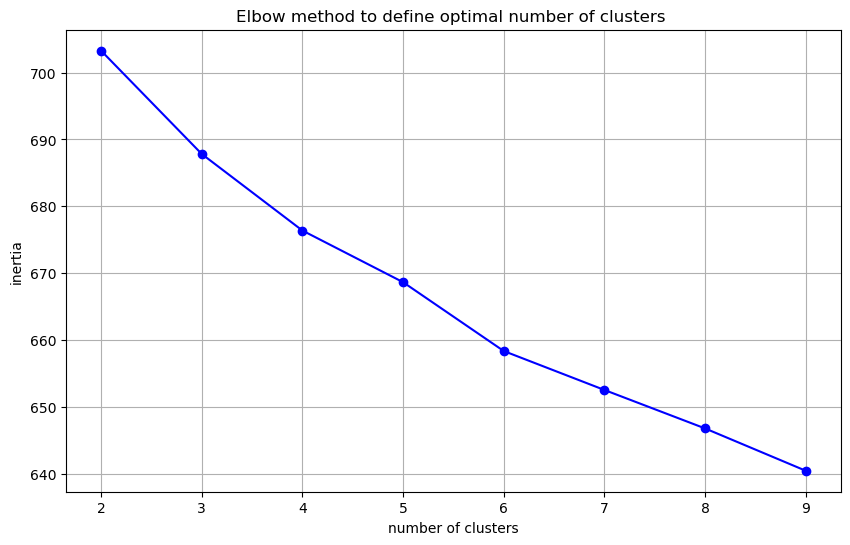

In [6]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, min_df=0.05, max_df=0.85, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(df_merged['Content_cleaned'])

# elbow method to choose the optimal number of clusters 
inertia = []
K = range(2, 10) 

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.title('Elbow method to define optimal number of clusters ')
plt.grid(True)
plt.show()

Considering the plot, inertia rapidly drops until reaching 6 numbers of clusters, and then it still drops but in a smoother way. We chose to use 6 numbers of clusters since this number also corresponds to the number of historical periods we have defined. Additionally, since our main interest in conducting this specific analysis was assessing whether speeches naturally cluster by historical periods or topics, an excessive number of clusters would not be useful in serving this purpose.

## Visualizing K-Means Clusters Using PCA

We reduce dimensionality to 2 Principal Components, to allow for a visual representations of the clusters. 

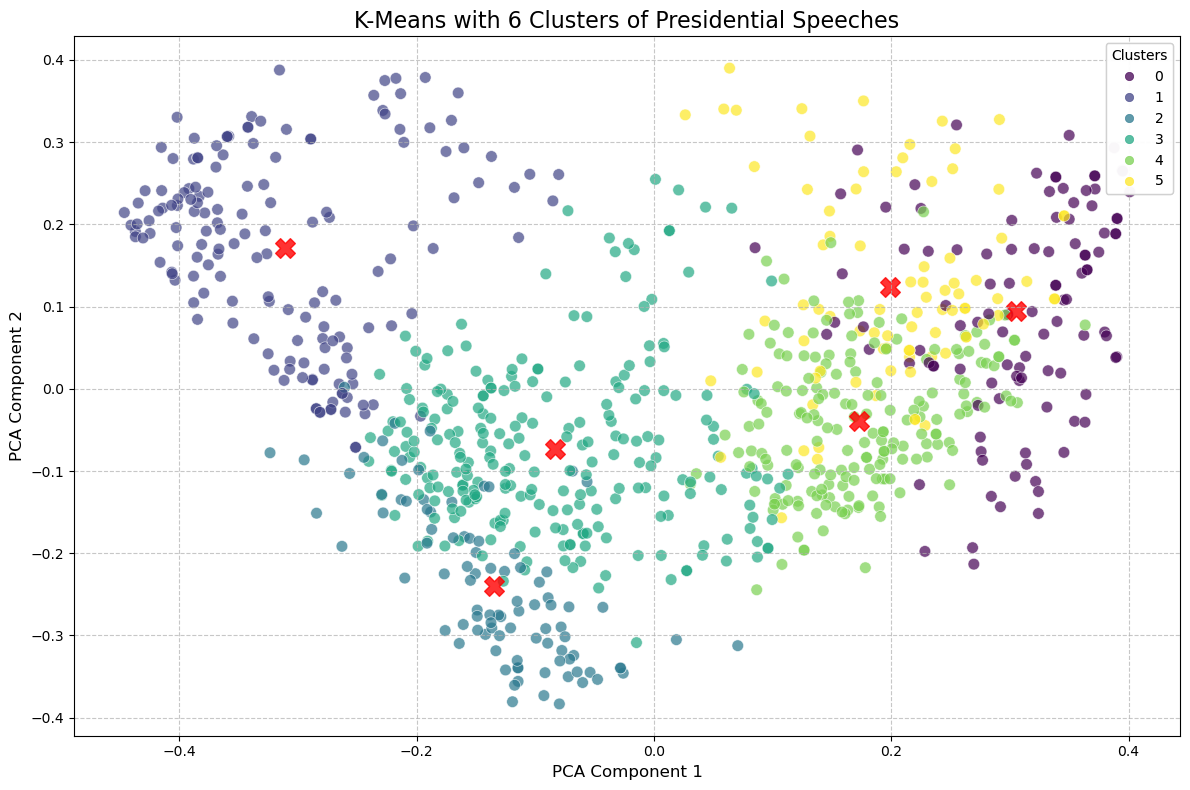

In [ ]:
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=40)
df_merged["KMeans_Cluster"] = kmeans.fit_predict(X_tfidf)

def plot_kmeans_clusters(X_tfidf, df, n_clusters):
    # Apply K-means with the specified number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_tfidf)
    
    # Create a temporary dataframe copy with the cluster assignments
    temp_df = df_merged.copy()
    temp_df["KMeans_Cluster"] = cluster_labels
    
    # Reduce TF-IDF feature space to 2 dimensions
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_tfidf.toarray())  
    
    # Add PCA components to temporary DataFrame
    temp_df["PCA1"] = X_pca[:, 0]
    temp_df["PCA2"] = X_pca[:, 1]
    
    # Create a color map with distinct colors
    cmap = plt.colormaps['viridis'].resampled(n_clusters)
    
    # Scatter plot of K-Means clusters
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(temp_df["PCA1"], temp_df["PCA2"], c=temp_df["KMeans_Cluster"], 
                         cmap=cmap, alpha=0.7, s=70, edgecolors='w', linewidth=0.5)
    
    # Add the legend
    legend1 = plt.legend(*scatter.legend_elements(),
                        title="Clusters", loc="upper right")
    plt.gca().add_artist(legend1)
    
    # Plot centroids 
    centers = kmeans.cluster_centers_
    # Transform centroids to PCA space
    centers_pca = pca.transform(centers)
    plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', 
                s=200, alpha=0.8, marker='X', label='Cluster Centers')
    
    plt.xlabel("PCA Component 1", fontsize=12)
    plt.ylabel("PCA Component 2", fontsize=12)
    plt.title(f"K-Means with {n_clusters} Clusters of Presidential Speeches", fontsize=16)
    
    # Add grid 
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return temp_df["KMeans_Cluster"]  

# Create plot
cluster_assignments_6 = plot_kmeans_clusters(X_tfidf, df_merged, 6)

While acknowledging that reducing all features to a 2-dimensional space makes the visualization not fully reliable, we still appreciate the fact that some clusters appear to be well separated (clusters 1, 2, and 3) while others show considerable overlap (clusters 0, 4, and 5). This pattern suggests that certain clusters might effectively identify specific topics and/or historical periods, while others represent more nebulous or overlapping linguistic characteristics. The distinct separation of clusters 1, 2, and 3 indicates they may capture unique linguistic patterns associated with particular eras or themes in presidential rhetoric, whereas the overlapping nature of clusters 0, 4, and 5 might reflect shared vocabulary or rhetorical approaches that transcend specific time periods.

To define patterns, we plot a heatmap that shows how many speeches are assigned to each cluster across all historical periods.

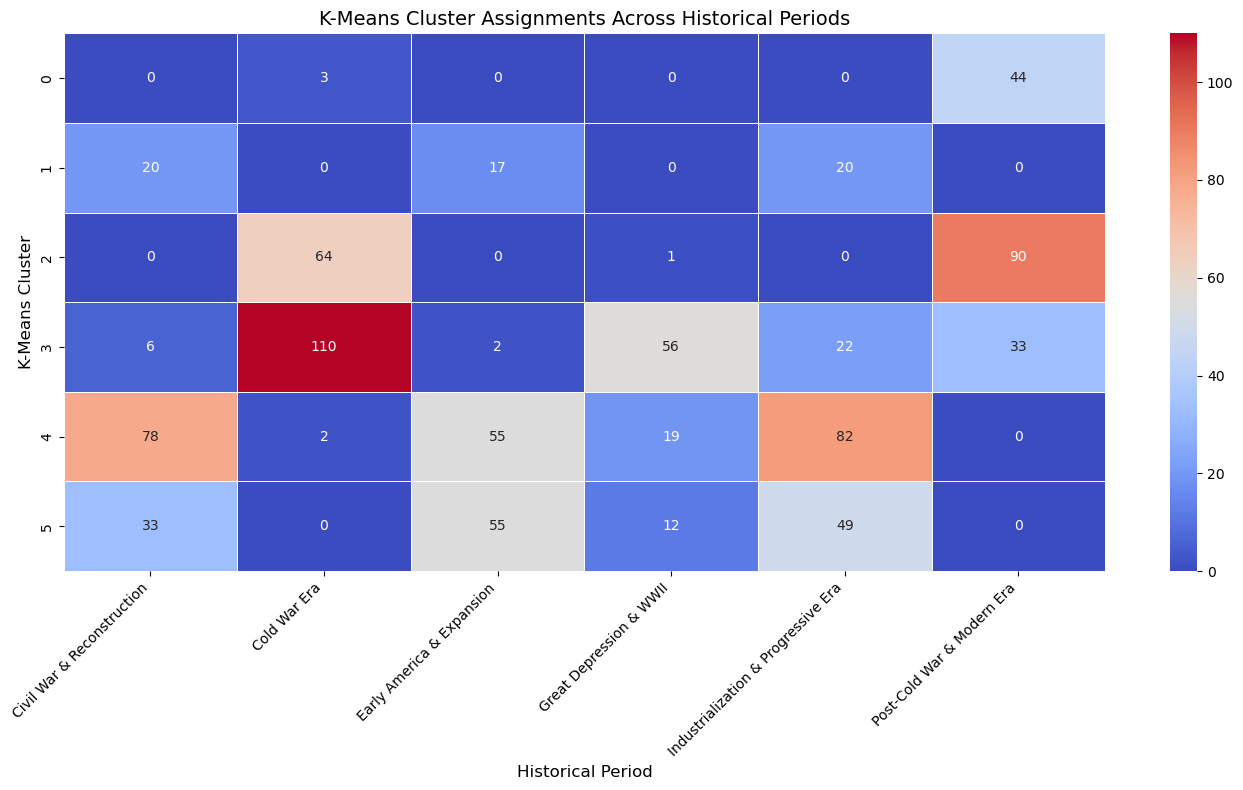

In [ ]:
# Distribution of clusters across historical periods
summary_df = df_merged.groupby(["KMeans_Cluster", "Historical_Period"]).size().reset_index(name="Speech_Count") 
cluster_periods = summary_df.pivot(index="KMeans_Cluster", columns="Historical_Period", values="Speech_Count").fillna(0)
plt.figure(figsize=(14, 8))  
sns.heatmap(cluster_periods, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5)
plt.xlabel("Historical Period", fontsize=12)
plt.ylabel("K-Means Cluster", fontsize=12)
plt.title("K-Means Cluster Assignments Across Historical Periods", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()   
plt.show()

We can see that there is no perfect correspondence between clusters and historical periods. Nevertheless, clear patterns emerge from the distribution. Precisely, we can highlight the following significant relationships:

- **Cluster 2**: Dominates the Cold War Era and in the Post-Cold War & Modern Era ->  represents recent rhetoric
- **Cluster 3**: Most prominent in Cold War Era and in the Great Depression & WWII Era -> indicates war speeches
- **Cluster 4**: Present in Civil War & Reconstruction, Early American & Expansion and Industrilization & Progressive Era → represents earlier history

The word clouds that follows further confirm our hypothesis:

- **Cluster 2** features words such as: ''applause', 'think', 'time',
- **Cluster 3** emphasizes: 'world', 'war', 'must', 'peace'
- **Cluster 4** centers on: 'constitution', 'congress', 'law', 'territory', 'power'

This analysis confirms that presidential speech themes evolve in response to major historical events while also maintaining certain rhetorical traditions, reinforcing the validity of our clustering approach and providing insight into how presidential rhetoric adapts to changing national circumstances.

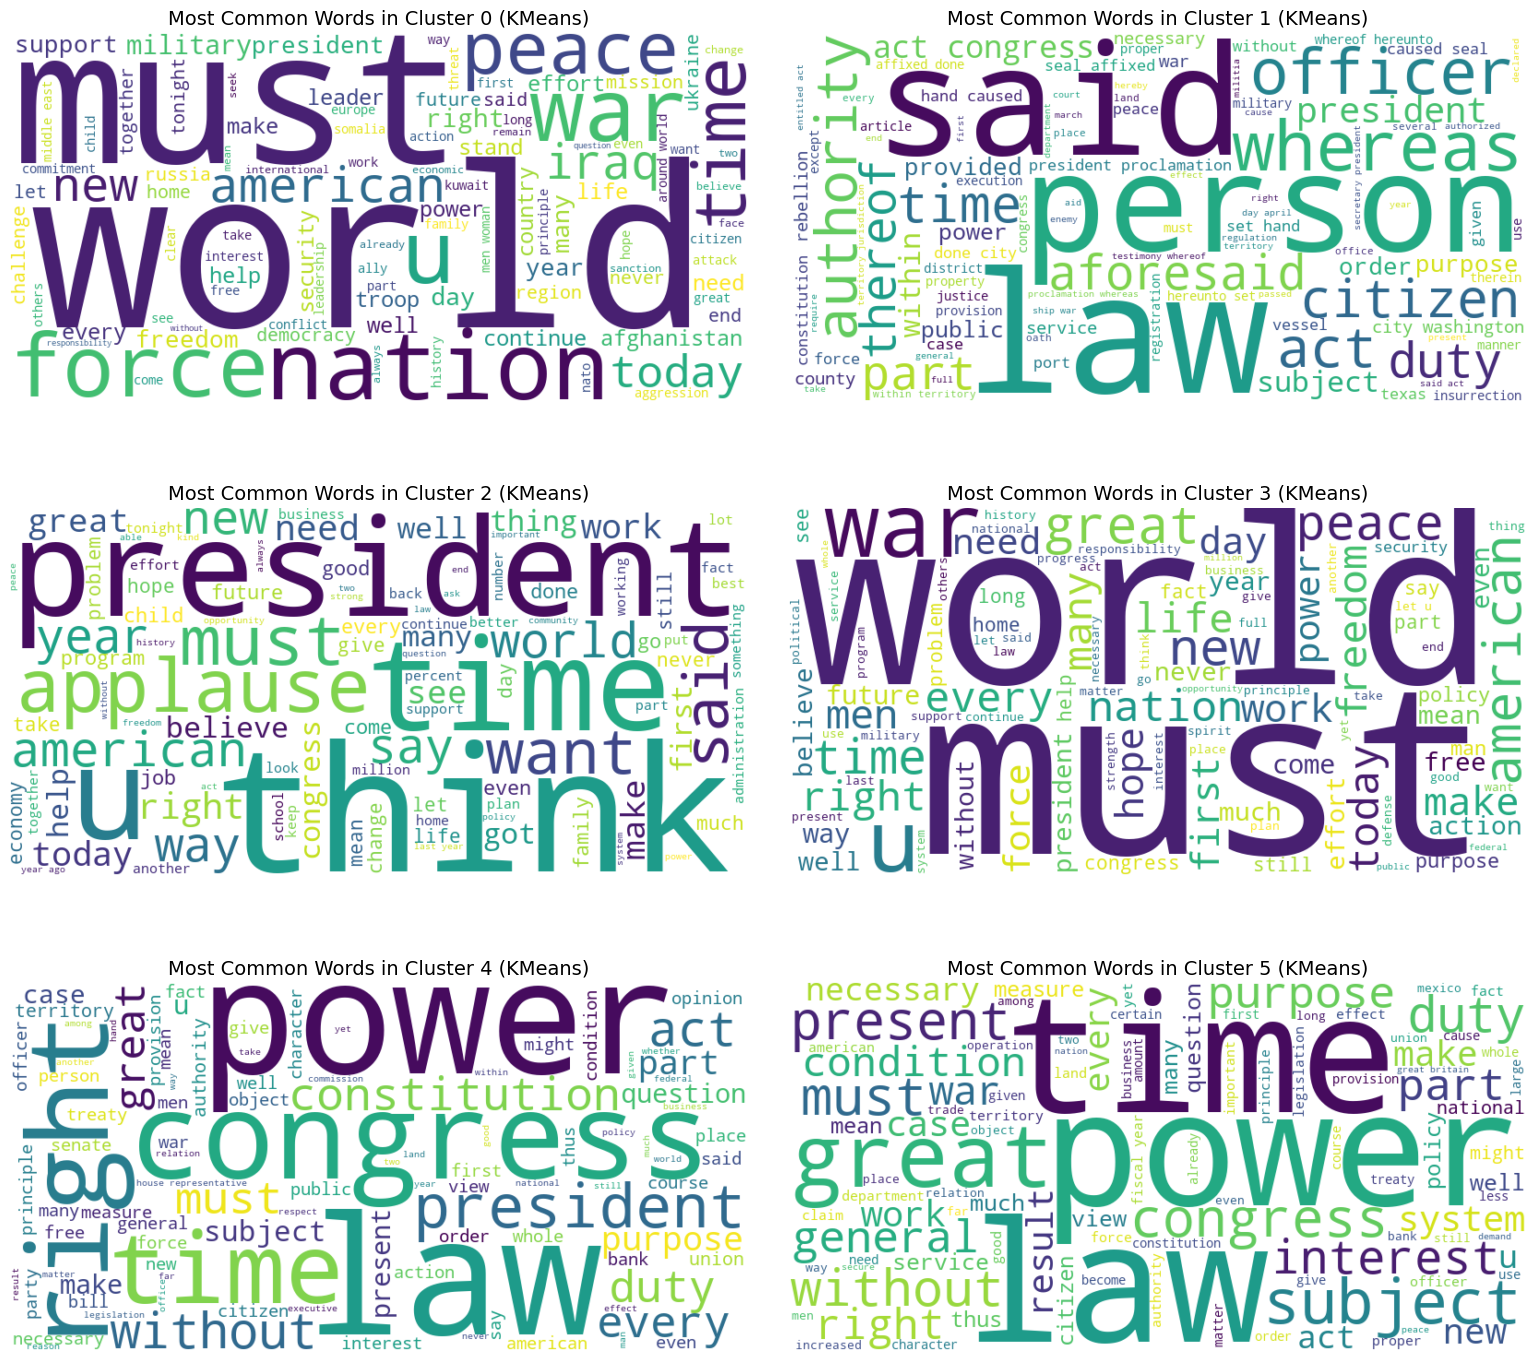

In [ ]:
# Function to generate word clouds for each cluster
def generate_wordclouds(num_clusters, model="KMeans"):
    num_rows = (num_clusters + 1) // 2  
    fig, axes = plt.subplots(num_rows, 2, figsize=(16, 5 * num_rows))

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    for cluster in range(num_clusters):
        # Get the current axis
        ax = axes[cluster]

        # Extract text for the current cluster
        text = " ".join(df_merged[df_merged[f"{model}_Cluster"] == cluster]["Content_cleaned"])

        # Generate wordcloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color="white",
            max_words=100,
            contour_width=1,
            contour_color="steelblue",
            random_state=42).generate(text)

        # Display the wordcloud on the current subplot
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.set_title(f"Most Common Words in Cluster {cluster} ({model})", fontsize=14)
        ax.axis("off")

    plt.tight_layout(pad=3)
    plt.show()

# Generate word clouds for KMeans clusters
generate_wordclouds(num_clusters, "KMeans")

## Feature Extraction 

In [10]:
# Define words associated with a range of emotions - for more nuanced analysis beyond positive/negative
def analyze_emotions(text):
    if not isinstance(text, str) or not text:
        return {"optimism": 0, "concern": 0, "confidence": 0, "uncertainty": 0}

    emotions = {
        "optimism": ["growth", "recovery", "opportunity", "improve", "progress", "hope", "prosper"],
        "concern": ["challenge", "difficult", "concerned", "problem", "issue", "worry"],
        "confidence": ["confident", "certain", "assured", "strong", "robust", "resilient"],
        "uncertainty": ["uncertain", "unclear", "may", "might", "possible", "perhaps", "risk"]}

    result = {}
    for emotion, keywords in emotions.items():
        score = sum(1 for word in text.lower().split() if word in keywords)
        result[emotion] = score / max(len(text.split()), 1)  

    return result

# Apply emotion analysis to all speech content
emotion_scores = df_merged["Content_cleaned"].apply(analyze_emotions).tolist()
emotion_df = pd.DataFrame(emotion_scores)
df_merged = pd.concat([df_merged, emotion_df], axis=1)

# Define different framing approaches
def identify_frames(text):
    if not isinstance(text, str) or not text:
        return {"crisis_frame": 0,  "leadership_frame": 0, "values_frame": 0, "reform_frame": 0, "dominant_frame": "neutral_frame"}

    frames = {
        "crisis_frame": ["crisis", "emergency", "threat", "disaster", "severe", "urgent", "catastrophe", 
                         "danger", "instability", "chaos", "collapse", "hardship", "challenge", "difficult", 
                         "struggle", "problem", "deficit", "recession", "conflict", "war", "attack", "enemy", 
                         "fear", "anxiety", "concern", "worry", "trouble", "decline", "deterioration"],
                         
        "opportunity_frame": ["opportunity", "possibility", "potential", "promise", "progress",  "innovation",
                               "advancement", "prosperity", "renewal", "hope",  "growth", "recovery", "improvement", 
                               "development", "success", "achievement", "optimism", "confidence", "faith", "trust", 
                               "belief", "future", "vision", "dream", "aspiration", "ambition", "inspiration", "motivation"],

        "leadership_frame": ["responsibility", "duty", "obligation", "accountability", "commitment",  
                             "leadership", "public service", "security", "safety", "protection",
                             "authority", "control", "command", "guidance", "direction", "governance",
                             "determination", "strength", "power", "influence", "competence", "capability"],
                         
        "values_frame": ["fair", "equitable", "just", "equality", "disparity", "gap", "justice", "rights", 
                         "inclusion", "balance", "equity", "access", "representation", "solidarity",
                         "freedom", "liberty", "democracy", "constitution", "principles", "ideals", "morals",
                         "ethics", "dignity", "respect", "tolerance", "diversity", "unity", "cooperation"]}

    result = {}
    for frame, keywords in frames.items():
        score = sum(1 for word in text.lower().split() if word in keywords)
        result[frame] = score / max(len(text.split()), 1)  

    # Determine dominant framing approach
    if sum(result.values()) > 0:
        result["dominant_frame"] = max(result.items(), key=lambda x: x[1])[0]
    else:
        result["dominant_frame"] = "neutral_frame"

    return result

# Apply framing analysis to all speech content
frame_scores = df_merged["Content_cleaned"].apply(identify_frames).tolist()
frame_df = pd.DataFrame(frame_scores)
df_merged = pd.concat([df_merged, frame_df], axis=1)

# define economic themes
economic_themes = {
    "jobs_employment": ["job", "employment", "unemployment", "work", "labor", "workforce", "hire", "hiring", "layoff"],
    "inflation_prices": ["inflation", "price", "cost", "purchasing power", "dollar value", "expensive", "affordable", "consumer price", "cpi"],
    "fiscal_policy": ["tax", "taxation", "spend", "spending", "budget", "deficit", "debt", "fiscal", "revenue", "expenditure", "stimulus"],
    "monetary_policy": ["interest rate", "federal reserve", "fed", "money supply", "monetary", "central bank", "banking system", "financial system", "currency"],
    "international_trade": [ "trade", "export", "import", "tariff", "global", "international", "foreign", "overseas", "commerce"],
    "inequality": ["inequality", "gap", "wealth", "poor", "rich", "middle class", "income", "distribution", "disparity", "poverty", "prosperity", "equal opportunity"]}

# add the column 'dominant_theme' to both dataframes
def get_dominant_theme(text):
    if not isinstance(text, str):
        return None  
    
    theme_counts = {}
    total_theme_mentions = 0
    
    for theme, keywords in economic_themes.items():
        count = 0
        for keyword in keywords:
            pattern = r'\b' + re.escape(keyword) + r'\b'
            matches = re.findall(pattern, text.lower())
            count += len(matches)
        theme_counts[theme] = count
        total_theme_mentions += count
    
    if total_theme_mentions > 0:
        dominant_theme = max(theme_counts.items(), key=lambda x: x[1])[0]
    else:
        dominant_theme = None
    
    return dominant_theme

df_merged['dominant_theme'] = df_merged['Content_cleaned'].apply(get_dominant_theme)

## Sentiment Analysis

In [11]:
# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis to all speeches
df_merged["General_Sentiment"] = df_merged["Content_cleaned"].apply(
    lambda text: analyzer.polarity_scores(text)["compound"] if isinstance(text, str) else None)

After conducting our preliminary analysis using only textual data, we now divide our dataset into two distinct subsets to explore different analytical approaches and assess which provides more robust classification capabilities:

- **df_historical**: Contains all presidential speeches (from 1789 to 2025) but lacks macroeconomic indicators. This dataset offers a longer historical timeline but relies solely on linguistic features for classification.
- **df_economic**: Contains both speech text and numerical macroeconomic indicators, but is limited to the period from 1950 onwards when comprehensive economic data becomes available. This dataset offers richer feature dimensionality but covers a shorter historical period.

This comparative approach will allow us to evaluate the trade-off between temporal coverage and feature richness, helping us determine whether the addition of economic context indicators significantly improves our ability to classify presidential rhetoric, or if linguistic patterns alone provide sufficient classification power across the full historical timeline. 

In [12]:
# Create a copy of the whole dataset
df_full = df_merged.copy()

# Create the two dataframes  
df_historical = df_full.drop(columns=['GDPCA', 'GDP_growth', 'Unemployment_Rate', 'Inflation_Rate'])
df_economic = df_full[df_full['Year'] >= 1950].copy()  

## Sentiment Analysis vs Economic Indicators (df_economic)

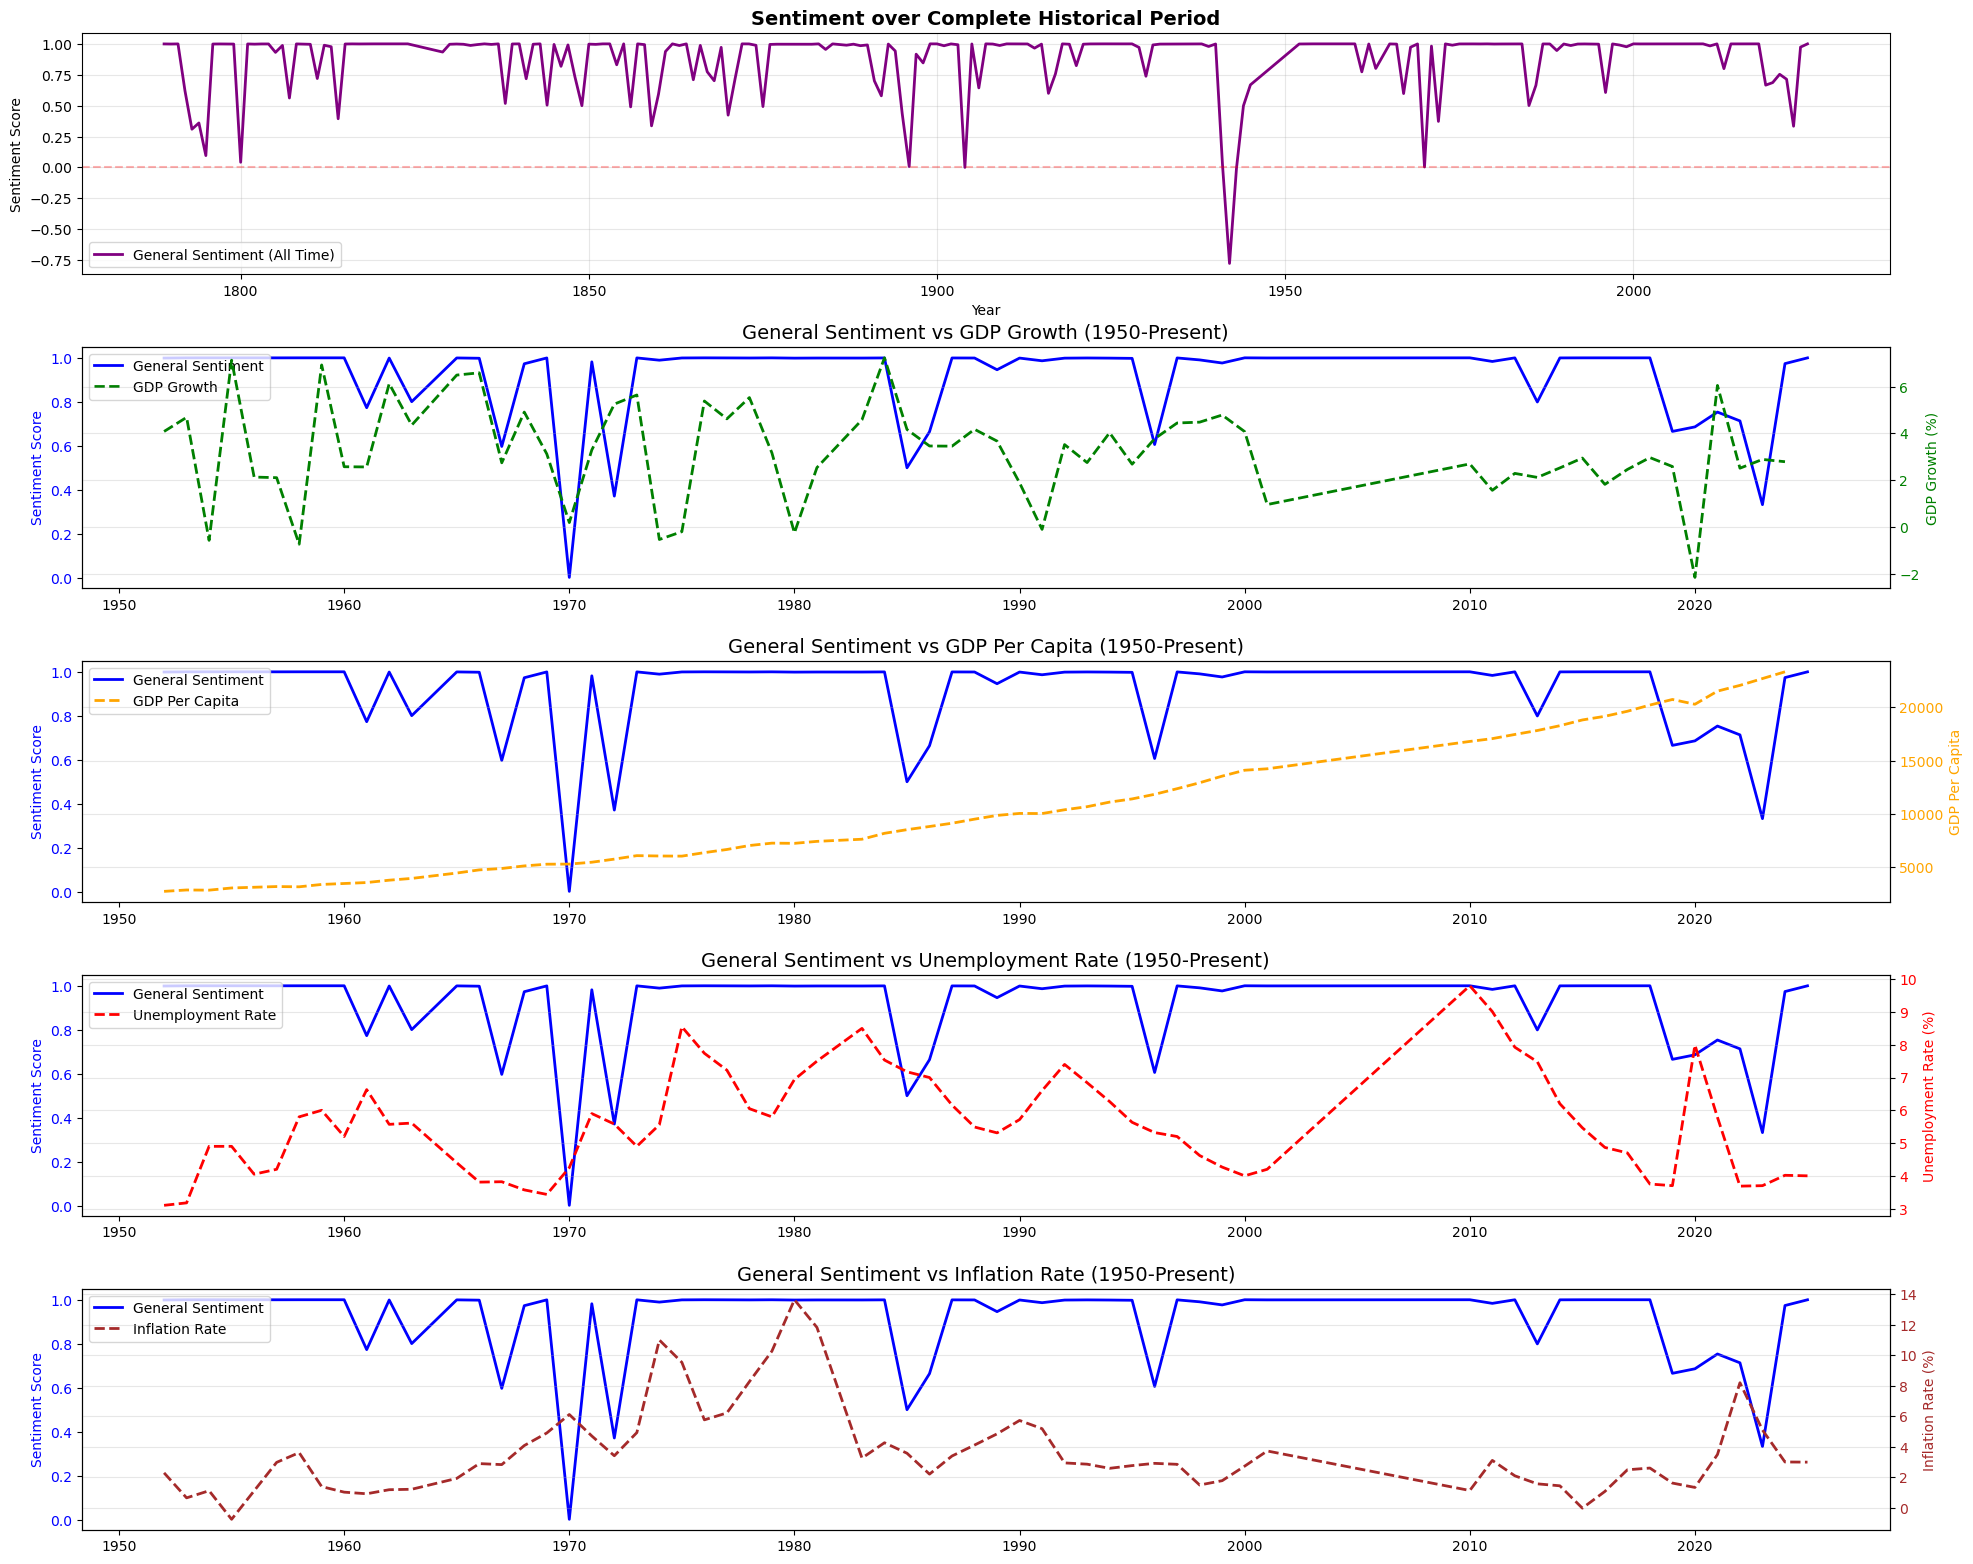

In [ ]:
# Visualize the evolution of sentiment over time with all economic variables
plt.figure(figsize=(20, 16))  

# Complete dataset - Sentiment over time
plt.subplot(5, 1, 1)
df_historical.groupby('Year')['General_Sentiment'].mean().plot(
    color='purple', linewidth=2, label='General Sentiment (All Time)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.title('Sentiment over Complete Historical Period', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylabel('Sentiment Score')

# Economic dataset - Sentiment vs GDP Growth
plt.subplot(5, 1, 2)
ax1 = plt.gca()
ax2 = ax1.twinx()

# Sentiment
ax1.plot(df_economic.groupby('Year')['General_Sentiment'].mean(), 
        color='blue', linewidth=2, label='General Sentiment')
ax1.set_ylabel('Sentiment Score', color='blue', fontsize=10)
ax1.tick_params(axis='y', labelcolor='blue')

# GDP growth
ax2.plot(df_economic.groupby('Year')['GDP_growth'].mean(), 
        color='green', linewidth=2, label='GDP Growth', linestyle='--')
ax2.set_ylabel('GDP Growth (%)', color='green', fontsize=10)
ax2.tick_params(axis='y', labelcolor='green')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('General Sentiment vs GDP Growth (1950-Present)', fontsize=14)
plt.grid(True, alpha=0.3)

# Economic dataset - Sentiment vs GDP Per Capita
plt.subplot(5, 1, 3)
ax1 = plt.gca()
ax2 = ax1.twinx()

# Sentiment
ax1.plot(df_economic.groupby('Year')['General_Sentiment'].mean(), 
        color='blue', linewidth=2, label='General Sentiment')
ax1.set_ylabel('Sentiment Score', color='blue', fontsize=10)
ax1.tick_params(axis='y', labelcolor='blue')

# GDP per capita
ax2.plot(df_economic.groupby('Year')['GDPCA'].mean(), 
        color='orange', linewidth=2, label='GDP Per Capita', linestyle='--')
ax2.set_ylabel('GDP Per Capita', color='orange', fontsize=10)
ax2.tick_params(axis='y', labelcolor='orange')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('General Sentiment vs GDP Per Capita (1950-Present)', fontsize=14)
plt.grid(True, alpha=0.3)

# Economic dataset - Sentiment vs Unemployment
plt.subplot(5, 1, 4)
ax1 = plt.gca()
ax2 = ax1.twinx()

# Sentiment
ax1.plot(df_economic.groupby('Year')['General_Sentiment'].mean(), 
        color='blue', linewidth=2, label='General Sentiment')
ax1.set_ylabel('Sentiment Score', color='blue', fontsize=10)
ax1.tick_params(axis='y', labelcolor='blue')

# Unemployment
ax2.plot(df_economic.groupby('Year')['Unemployment_Rate'].mean(), 
        color='red', linewidth=2, label='Unemployment Rate', linestyle='--')
ax2.set_ylabel('Unemployment Rate (%)', color='red', fontsize=10)
ax2.tick_params(axis='y', labelcolor='red')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('General Sentiment vs Unemployment Rate (1950-Present)', fontsize=14)
plt.grid(True, alpha=0.3)

# Economic dataset - Sentiment vs Inflation
plt.subplot(5, 1, 5)
ax1 = plt.gca()
ax2 = ax1.twinx()

# Sentiment
ax1.plot(df_economic.groupby('Year')['General_Sentiment'].mean(), 
        color='blue', linewidth=2, label='General Sentiment')
ax1.set_ylabel('Sentiment Score', color='blue', fontsize=10)
ax1.tick_params(axis='y', labelcolor='blue')

# Inflation
ax2.plot(df_economic.groupby('Year')['Inflation_Rate'].mean(), 
        color='brown', linewidth=2, label='Inflation Rate', linestyle='--')
ax2.set_ylabel('Inflation Rate (%)', color='brown', fontsize=10)
ax2.tick_params(axis='y', labelcolor='brown')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('General Sentiment vs Inflation Rate (1950-Present)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout(pad=2.0)
plt.subplots_adjust(hspace=0.3)
plt.show()

**Presidential Sentiment Trend (1789-Present)**: Throughout American history, presidential rhetoric has generally maintained a positive sentiment, with notable exceptions during times of crisis or war. These sharp drops in sentiment are likely linked to significant events that the nation faced, such as wars or other periods of major uncertainty.

**Presidential Sentiment and GDP Growth**: A positive correlation between presidential sentiment and GDP growth can be observed during specific periods, such as the late 1960s and early 1970s. However, this relationship is not always consistent. For instance, during the 2008 financial crisis, sentiment remained surprisingly high despite negative GDP growth. In contrast, during the 2020 COVID-19 pandemic, they both dropped, and GDP recovered faster while sentiment remained lower for longer.  

**Presidential Sentiment and GDP Per Capita**: There seems to be absence of correlation between sentiment and GDP per capita over time. While GDP per capita steadily increases, sentiment fluctuates more independently, not following a linear trend. 

**Presidential Sentiment and Unemployment Rate**: A clear inverse relationship is noticeable during key periods - when unemployment rises, sentiment tends to fall. This pattern is evident during multiple periods, such as the 1970s and the 1980s.  

**Presidential Sentiment and Inflation Rate**: The relationship between sentiment and inflation is more complex. During periods of high inflation, such as the 1970s and early 1980s, we observe drops in sentiment, but they do not align exactly with the inflation spikes. This suggests that the drops in sentiment may actually be independent of the high inflation. In contrast, the recent surge in inflation during 2021-2022 is perfectly aligned with a drop in sentiment.

Correlation between Economic Health Index and Presidential Sentiment: -0.05835586944287417


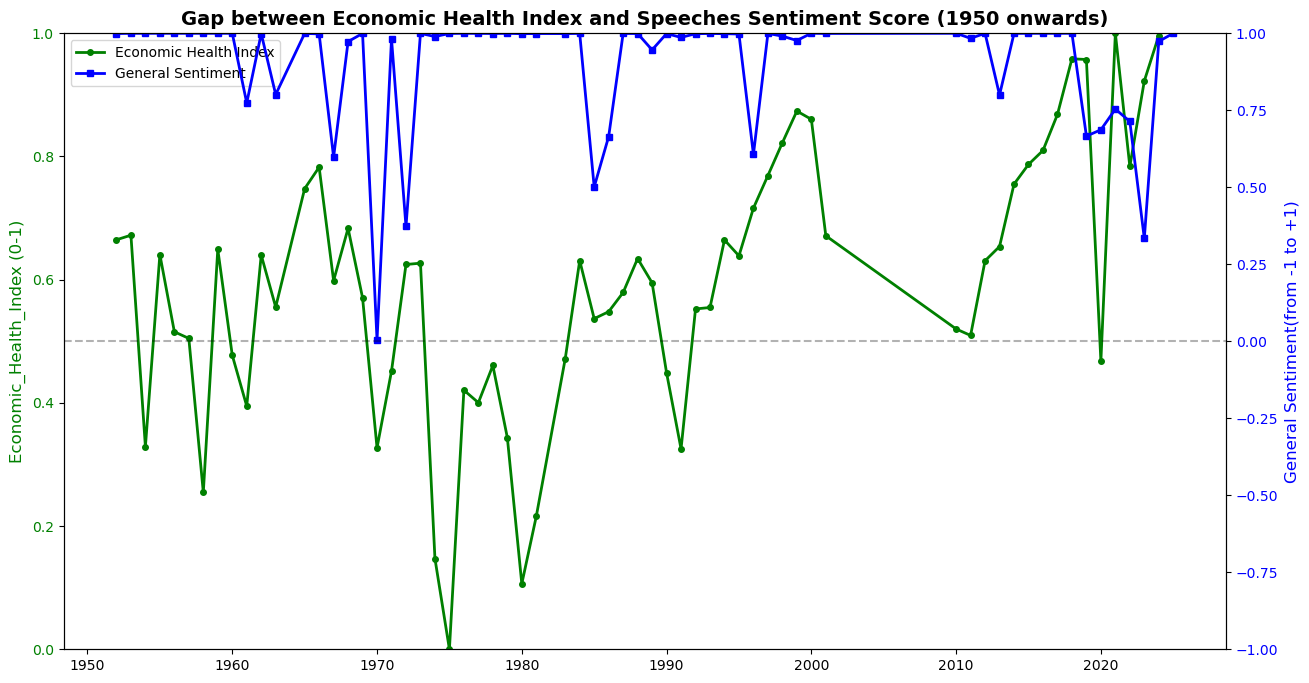

In [ ]:
# create an index - with the available macroeconomic indicators - that tells how well is the economy 
def create_economic_health_index(df):
    yearly_data = df.groupby('Year').agg({
        'GDP_growth': 'mean',
        'GDPCA': 'mean',  # GDP per capita
        'Unemployment_Rate': 'mean',
        'Inflation_Rate': 'mean'}).reset_index()
    
    # standardize values 
    scaler = MinMaxScaler()
    
    # positive variables (the higher the better for the economy)
    yearly_data['GDP_growth_scaled'] = scaler.fit_transform(yearly_data[['GDP_growth']])
    yearly_data['GDPCA_scaled'] = scaler.fit_transform(yearly_data[['GDPCA']])
    
    # negative variables (the lower the better for the economy) -> we invert them 
    yearly_data['Unemployment_inverted'] = 1 - scaler.fit_transform(yearly_data[['Unemployment_Rate']])
    
    # for inflation, we use a gaussian transformation that assigns higher values to inflation rates close 
    # to 2% and lower values as they deviate from this optimum
    yearly_data['Inflation_optimum'] = np.exp(-0.5 * ((yearly_data['Inflation_Rate'] - 2) / 3)**2)
    
    # combine the transformed variables into an index with weights 
    yearly_data['Economic_Health_Index'] = (
        0.3 * yearly_data['GDP_growth_scaled'] +
        0.3 * yearly_data['GDPCA_scaled'] +
        0.25 * yearly_data['Unemployment_inverted'] +
        0.15 * yearly_data['Inflation_optimum'])
    
    # scale the index 
    yearly_data['Economic_Health_Index'] = scaler.fit_transform(yearly_data[['Economic_Health_Index']])
    
    return yearly_data

# apply the function to create the index 
economic_index = create_economic_health_index(df_economic)

# combine this index with the sentiment to plot them together 
sentiment_by_year = df_economic.groupby('Year')['General_Sentiment'].mean().reset_index()

comparison_data = pd.merge(economic_index[['Year', 'Economic_Health_Index']], 
                          sentiment_by_year, 
                          on='Year', how='left')

plt.figure(figsize=(15, 8))

ax1 = plt.gca()
ax2 = ax1.twinx()

line1 = ax1.plot(comparison_data['Year'], comparison_data['Economic_Health_Index'], 
         color='green', linewidth=2, marker='o', markersize=4, label='Economic Health Index')
ax1.set_ylabel('Economic_Health_Index (0-1)', color='green', fontsize=12)
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_ylim(0, 1)

# Sentiment
line2 = ax2.plot(comparison_data['Year'], comparison_data['General_Sentiment'], 
         color='blue', linewidth=2, marker='s', markersize=4, label='General Sentiment')
ax2.set_ylabel('General Sentiment(from -1 to +1)', color='blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-1, 1)

# line for the neutral sentiment 
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.title('Gap between Economic Health Index and Speeches Sentiment Score (1950 onwards)', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

# Add a column for the Economic Health Index to the economic_df
df_economic = pd.merge(df_economic, economic_index[['Year', 'Economic_Health_Index']], on='Year', how='left')

# Compute correlation between the economic health index and the sentiment 
correlation = df_economic['Economic_Health_Index'].corr(df_economic['General_Sentiment'])
print(f'Correlation between Economic Health Index and Presidential Sentiment: {correlation}')

The **Economic Health Index**, which combines GDP growth, GDP per capita, unemployment, and inflation into a single composite measure, reveals interesting patterns when compared to presidential speech sentiment from 1950 onwards. The first thing we could notice is that presidential sentiment consistently maintains much higher levels than the actual economic health of the country, creating a persistent "optimism gap" throughout the entire period.

This gap is particularly pronounced during economic downturns. The most dramatic example occurs around approximatively 1975-1980, when the Economic Health Index plummets to near zero due to the combination of high inflation, rising unemployment, and stagnant growth during the "stagflation" era. Despite this severe economic distress, presidential rhetoric maintains relatively high positive sentiment with only moderate dips, demonstrating how presidents attempt to project confidence even during the most challenging economic periods.

The relationship between these measures has evolved over time:
- During the 1950s the Presidential Sentiment shows great stability while the Economic Health Index has high volatility. This period is characterized by post-World War II economic growth and relative political stability. During this time, Presidential rhetoric largely reflects optimism, while the economy is still recovering.
- During the 1960s the Presidential Sentiment dramatically drops while the Economic Health Index has a big positive spike. 
- During the 1970s there is more volatility in both the Economic Health Index and Presidential Sentiment. This decade marks a period of economic downturns, including the oil crisis and rising inflation. While economic conditions deteriorate, Presidential Sentiment does not always reflect the gravity of the situation. 
- During the "stagflation" era there is the greatest divergence - as discussed before 
- During the 1990s  despite the economic expansion, the Presidential Sentiment shows a drastic drop, while the Economic Health Index keeps increasing. 
- The 2000s and 2010s show a widening gap again, with sentiment remaining exceptionally high despite fluctuations in economic health.
- During the late 2010s and into 2020, for the first time, the Economic Health Index surpasses Presidential Sentiment. This divergence may be explained by external shocks — such as the COVID-19 pandemic and the conflicts in Ukraine and Israel — which significantly shape presidential rhetoric without immediately impacting macroeconomic indicators to the same extent. 

Creating and plotting this composite Economic Health Index against the presidential speech sentiment reveals that, while presidents do adjust their rhetoric during severe economic crises, they consistently maintain more positive language than economic conditions would warrant. This persistent "optimism gap" suggests a fundamental aspect of presidential communication strategy: to acknowledge economic challenges while simultaneously projecting confidence that exceeds objective economic reality, perhaps to maintain public morale and confidence in leadership regardless of actual economic conditions.

We now introduce data on **Consumer Sentiment**. Given that Presidential Sentiment consistently remains higher than the Economic Health Index, adding this third dimension allows us to explore a key question: does presidential optimism — reflected in this persistent gap — influence public perception, or do people form their opinions solely based on tangible economic conditions and objective indicators?


The 'UMCSENT' index is provided by the University of Michigan where they construct and execute a Survey of Consumers in order to get a better understanding of people's perception about the economy. The Index of Consumer Sentiment (ICS) is computed using five key questions:


1. We are interested in how people are getting along financially these days. Would you say that you (and your family living there) are better off or worse off financially than you were a year ago?


2. Now looking ahead--do you think that a year from now you (and your family living there) will be better off financially, or worse off, or just about the same as now?  


3. Now turning to business conditions in the country as a whole--do you think that during the next twelve months we'll have good times financially, or bad times, or what?


4. Looking ahead, which would you say is more likely--that in the country as a whole we'll have continuous good times during the next five years or so, or that we will have periods of widespread unemployment or depression, or what?


5. About the big things people buy for their homes--such as furniture, a refrigerator, stove, television, and things like that. Generally speaking, do you think now is a good or bad time for people to buy major household items?


In summary, these five questions encompass different topics related to economic perception, such as individuals' past and future financial situations, current business conditions, long-term economic prospects, and the timing for any major purchases. The relative score is then calculated for each of the index questions, rounded to the nearest whole number, and the sum is then calculated. This sum is divided by the total for the 1966 base period and added by 2 in order to adjust for changes in sample design. This equation is shown as:

$$
ICS = \frac{X_1 + X_2 + X_3 + X_4 + X_5}{6.7558} + 2.0
$$

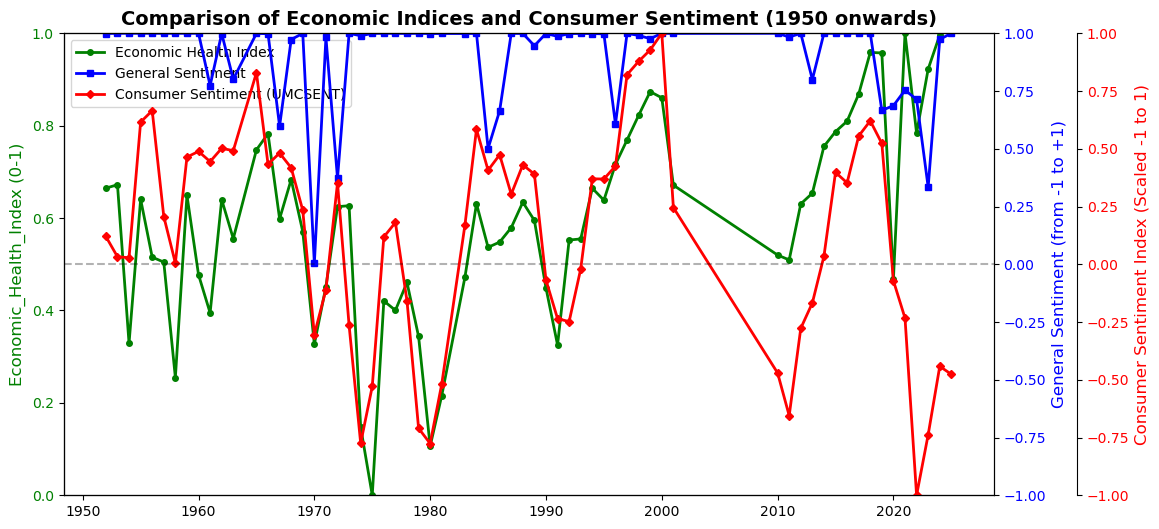

Correlation between Economic Health Index and Consumer Sentiment: 0.31199485393090615
Correlation between Presidential Sentiment and Consumer Sentiment: -0.0027141014373193214


In [ ]:
# Remove NaN rows
df_csentiment = df_csentiment.dropna().reset_index(drop=True)

# Convert the date column to datetime format
date_column = 'observation_date'
df_csentiment[date_column] = pd.to_datetime(df_csentiment[date_column])

# Extract the year from the date column
df_csentiment["Year"] = df_csentiment[date_column].dt.year

# Group by 'Year' and take the mean
df_csentiment2 = df_csentiment.groupby("Year").mean(numeric_only=True).reset_index()

# Rescale UMCSENT to range from -1 to 1
df_csentiment2["UMCSENT_Scaled"] = 2 * ((df_csentiment2["UMCSENT"] - df_csentiment2["UMCSENT"].min()) / 
                                      (df_csentiment2["UMCSENT"].max() - df_csentiment2["UMCSENT"].min())) - 1

# Merge both DataFrames on the 'Year' column
df_merged_full = comparison_data.merge(df_csentiment2[['Year', 'UMCSENT_Scaled']], on="Year", how="inner")

# Add the column 'UMCSENT_Scaled' to df_economic
df_economic = df_economic.merge(df_csentiment2[['Year', 'UMCSENT_Scaled']], on="Year", how="left")  

# Reproduce the plot done above adding consumers' sentiment 
plt.figure(figsize=(12, 6))

ax1 = plt.gca()
ax2 = ax1.twinx() 
ax3 = ax1.twinx()  

ax3.spines["right"].set_position(("outward", 60))

# Economic Health Index (Green Line)
line1 = ax1.plot(comparison_data['Year'], comparison_data['Economic_Health_Index'], 
                color='green', linewidth=2, marker='o', markersize=4, label='Economic Health Index')
ax1.set_ylabel('Economic_Health_Index (0-1)', color='green', fontsize=12)
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_ylim(0, 1)

# General Sentiment (Blue Line)
line2 = ax2.plot(comparison_data['Year'], comparison_data['General_Sentiment'], 
                color='blue', linewidth=2, marker='s', markersize=4, label='General Sentiment')
ax2.set_ylabel('General Sentiment (from -1 to +1)', color='blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-1, 1)

# Consumer Sentiment (Red Line)
line3 = ax3.plot(df_merged_full['Year'], df_merged_full['UMCSENT_Scaled'], 
                color='red', linewidth=2, marker='D', markersize=4, label='Consumer Sentiment (UMCSENT)')
ax3.set_ylabel('Consumer Sentiment Index (Scaled -1 to 1)', color='red', fontsize=12)
ax3.tick_params(axis='y', labelcolor='red')
ax3.set_ylim(-1, 1)

# Add horizontal line 
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)

# Title and Labels
plt.title('Comparison of Economic Indices and Consumer Sentiment (1950 onwards)', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)

# Merge all lines for legend
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')
plt.show()

correlation2 = df_economic['Economic_Health_Index'].corr(df_economic['UMCSENT_Scaled'])
print(f'Correlation between Economic Health Index and Consumer Sentiment: {correlation2}')

correlation3 = df_economic['General_Sentiment'].corr(df_economic['UMCSENT_Scaled'])
print(f'Correlation between Presidential Sentiment and Consumer Sentiment: {correlation3}')

Despite the persistent gap between Presidential Sentiment and the other indices, Consumer Sentiment generally appears to follow the trajectory of the economy, showing little evidence of being influenced by 'Presidential Optimism'. This divergence suggests that while presidential speeches may aim to shape public perception, they are not always successful in doing so. The public seems to respond more strongly to concrete economic signals rather than political narratives.

Interestingly, this pattern seems to reverse only after 2020. As previously discussed, this is the first period in which the Economic Health Index exceeds Presidential Sentiment — likely due to exceptional global events such as the COVID-19 pandemic and geopolitical conflicts. Moreover, for the first time, Consumer Sentiment aligns more closely with the trend of presidential rhetoric: both decline sharply, although the drop in consumer sentiment is more pronounced.

This shift may reflect a heightened collective awareness and emotional sensitivity within society, where global crises — such as devastating wars and unprecedented health emergencies — resonate deeply with public sentiment, beyond economic fundamentals.
Overall, the analysis indicates that while presidential rhetoric tends to maintain an inherently optimistic tone, its ability to influence public sentiment is limited and often overshadowed by real-world conditions and the collective emotional climate.

### Calculate the Readability Index 

We decided to calculate this additional feature because we thought that the level of complexity of a speech might be influenced by the topic. We expected to see a lower readability score (indicating more complex speeches) during periods of economic difficulty, while we expected to have higher readability scores (indicating more accessible speeches) in periods of prosperity.

Our analysis used the Flesch Reading Ease score, which evaluates text on a 100-point scale, with higher scores indicating more easily understood text. Contrary to our initial hypothesis, we did not find evidence that economic conditions consistently influenced speech complexity. Instead, the most striking pattern observed was a general trend toward increasingly readable presidential rhetoric over time.

This finding suggests that presidential communication has evolved to become more accessible to the general public, regardless of economic conditions or the topic. This likely reflects broader changes in political communication strategy, media environments and audience expectations. Despite not confirming our original hypothesis, this readability feature still provides valuable insights into the evolution of presidential communication styles and serves as a useful variable in our classification models.

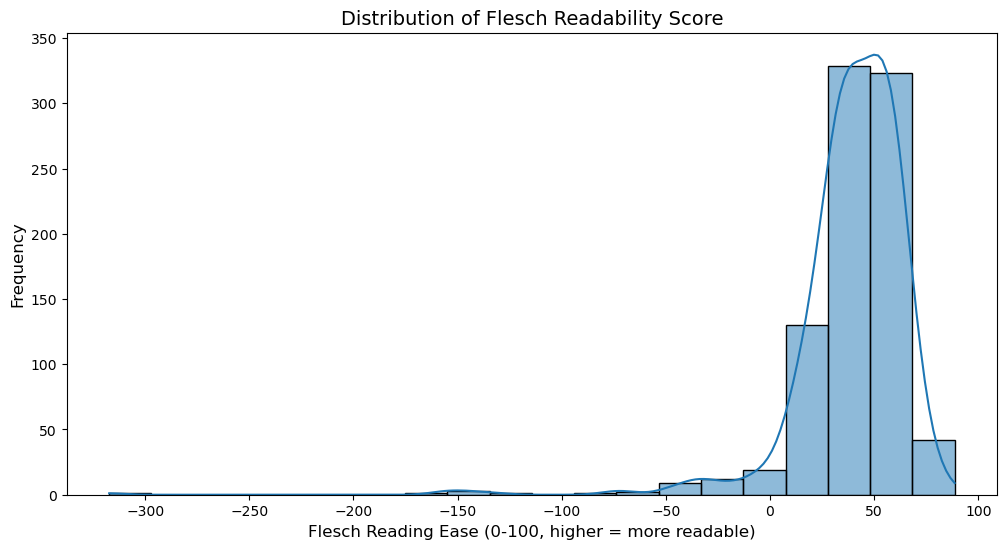

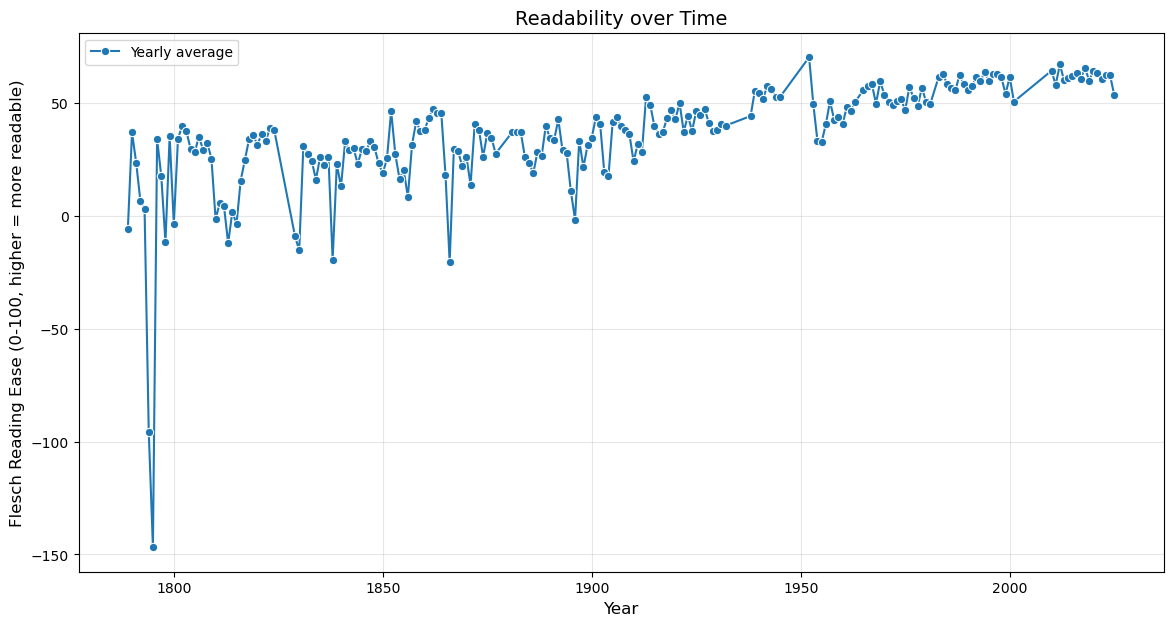

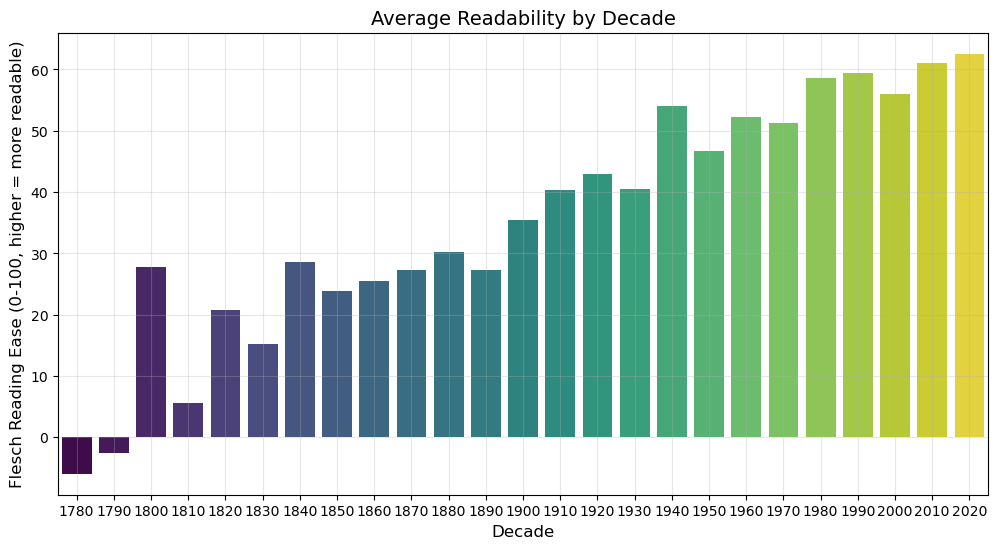

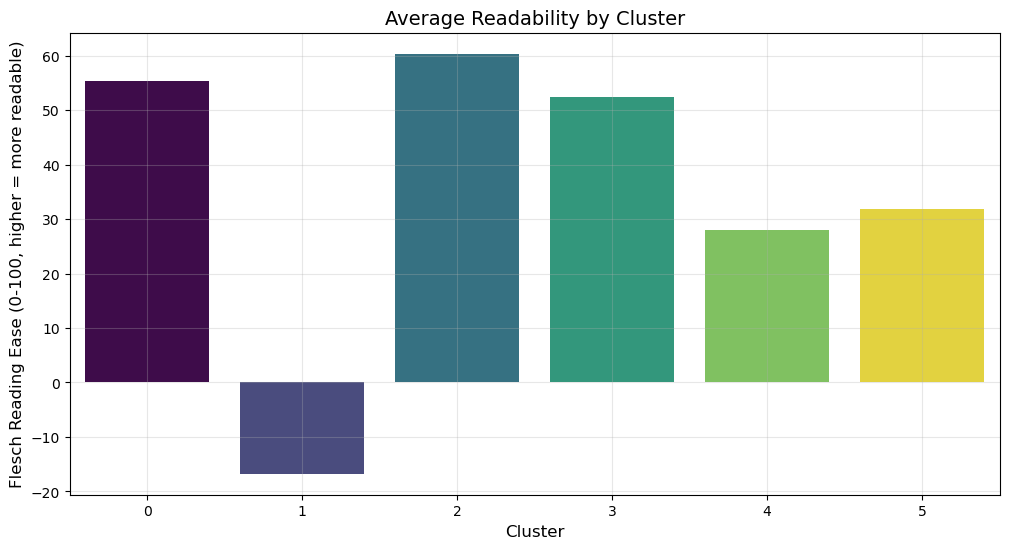

In [ ]:
def calculate_flesch_reading_ease(text):
    reading_ease = textstat.flesch_reading_ease(text)
    return reading_ease

def calculate_text_stats(df, text_column='Content'):
    result_df = df.copy()
    
    # Initialize read_index column
    result_df['read_index'] = np.nan
    
    for idx, text in enumerate(result_df[text_column]):
        if pd.isna(text) or text == "":
            continue
            
        # Calculate Flesch Readability Index 
        flesch_score = calculate_flesch_reading_ease(text)
        result_df.at[idx, 'read_index'] = flesch_score
    
    return result_df

def create_readability_visualizations(df):
    # Plot 1: Distribution of the index 
    plt.figure(figsize=(12, 6))
    sns.histplot(df['read_index'].dropna(), kde=True, bins=20)
    plt.title('Distribution of Flesch Readability Score', fontsize=14)
    plt.xlabel('Flesch Reading Ease (0-100, higher = more readable)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()
    
    # Plot 2: Evolution of the index over time
    plt.figure(figsize=(14, 7))
    years = sorted(df['Year'].unique())
    # Yearly average index 
    yearly_readability = df.groupby('Year')['read_index'].mean().reindex(years)
    sns.lineplot(x=yearly_readability.index, y=yearly_readability.values, marker='o', label='Yearly average')
    plt.title('Readability over Time', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Flesch Reading Ease (0-100, higher = more readable)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    # Plot 3: Index by decade
    plt.figure(figsize=(12, 6))
    decade_readability = df.groupby('Decade')['read_index'].mean()
    sns.barplot(x=decade_readability.index, y=decade_readability.values, 
                hue=decade_readability.index, legend=False, palette='viridis')
    plt.title('Average Readability by Decade', fontsize=14)
    plt.xlabel('Decade', fontsize=12)
    plt.ylabel('Flesch Reading Ease (0-100, higher = more readable)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

    # Plot 4: Index by cluster 
    plt.figure(figsize=(12,6))
    cluster_readability = df.groupby('KMeans_Cluster')['read_index'].mean()
    sns.barplot(x=cluster_readability.index, y=cluster_readability.values, 
                hue=cluster_readability.index, legend=False, palette='viridis')
    plt.title('Average Readability by Cluster', fontsize=14)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel('Flesch Reading Ease (0-100, higher = more readable)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

def analyze_readability(df, text_column='Content', create_plots=False):
    df_with_stats = calculate_text_stats(df, text_column)
    
    if create_plots:
        create_readability_visualizations(df_with_stats)
    
    return df_with_stats

# Calculate readability for both dataframes
df_historical = analyze_readability(df_historical, create_plots=True)
df_economic = analyze_readability(df_economic)

### Use variables defined throughout the analysis to determine the type of framing used by the president 

In [17]:
df_economic['dominant_frame'].value_counts()

dominant_frame
opportunity_frame    135
crisis_frame         118
leadership_frame      48
values_frame          39
Name: count, dtype: int64

In [18]:
df_historical['dominant_frame'].value_counts()

dominant_frame
leadership_frame     383
crisis_frame         207
opportunity_frame    203
values_frame          76
neutral_frame          4
Name: count, dtype: int64

We have unbalanced classes so we need to handle it while training the models. 


Model Performance Metrics:
Accuracy:  0.6804
Precision: 0.6789
Recall:    0.6804
F1-Score:  0.6590


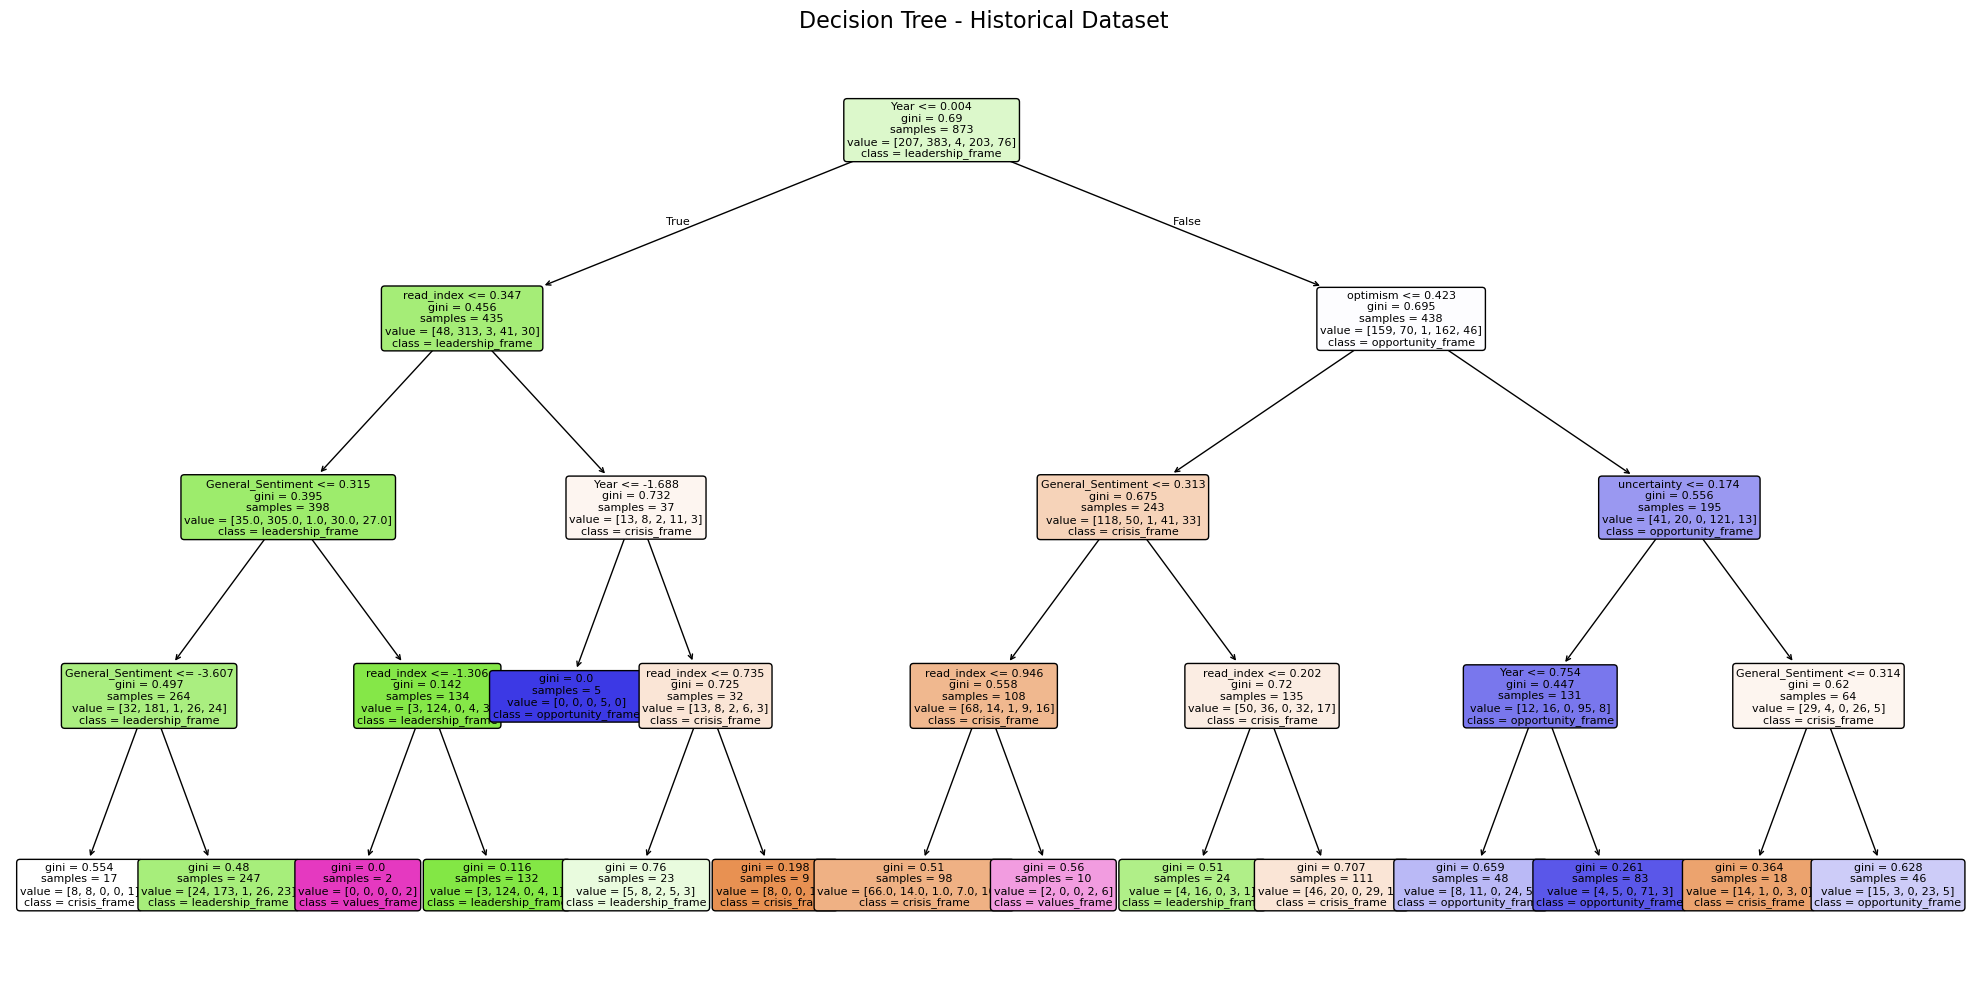

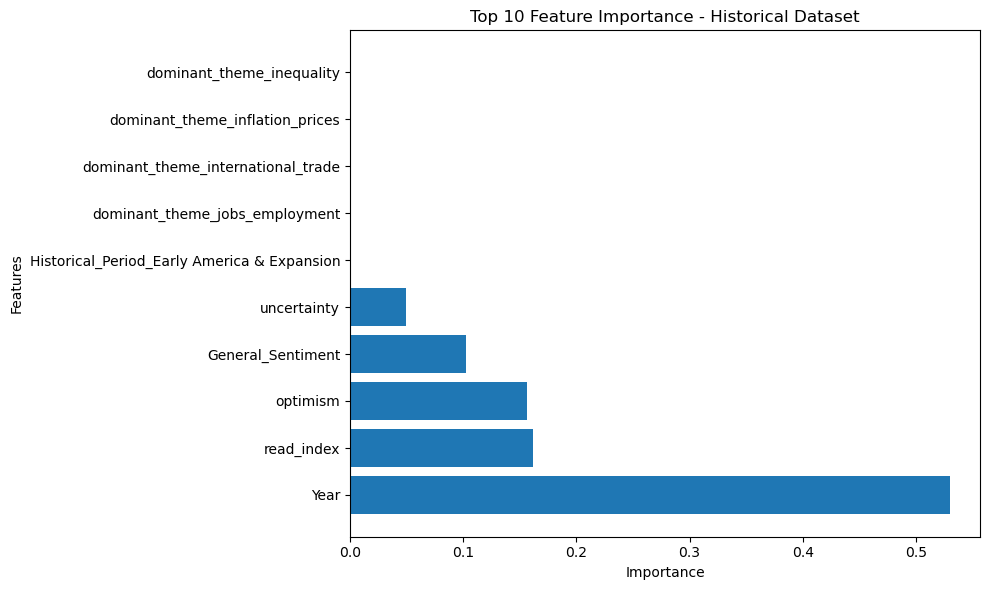


Model Performance Metrics:
Accuracy:  0.6095
Precision: 0.5500
Recall:    0.6095
F1-Score:  0.5498


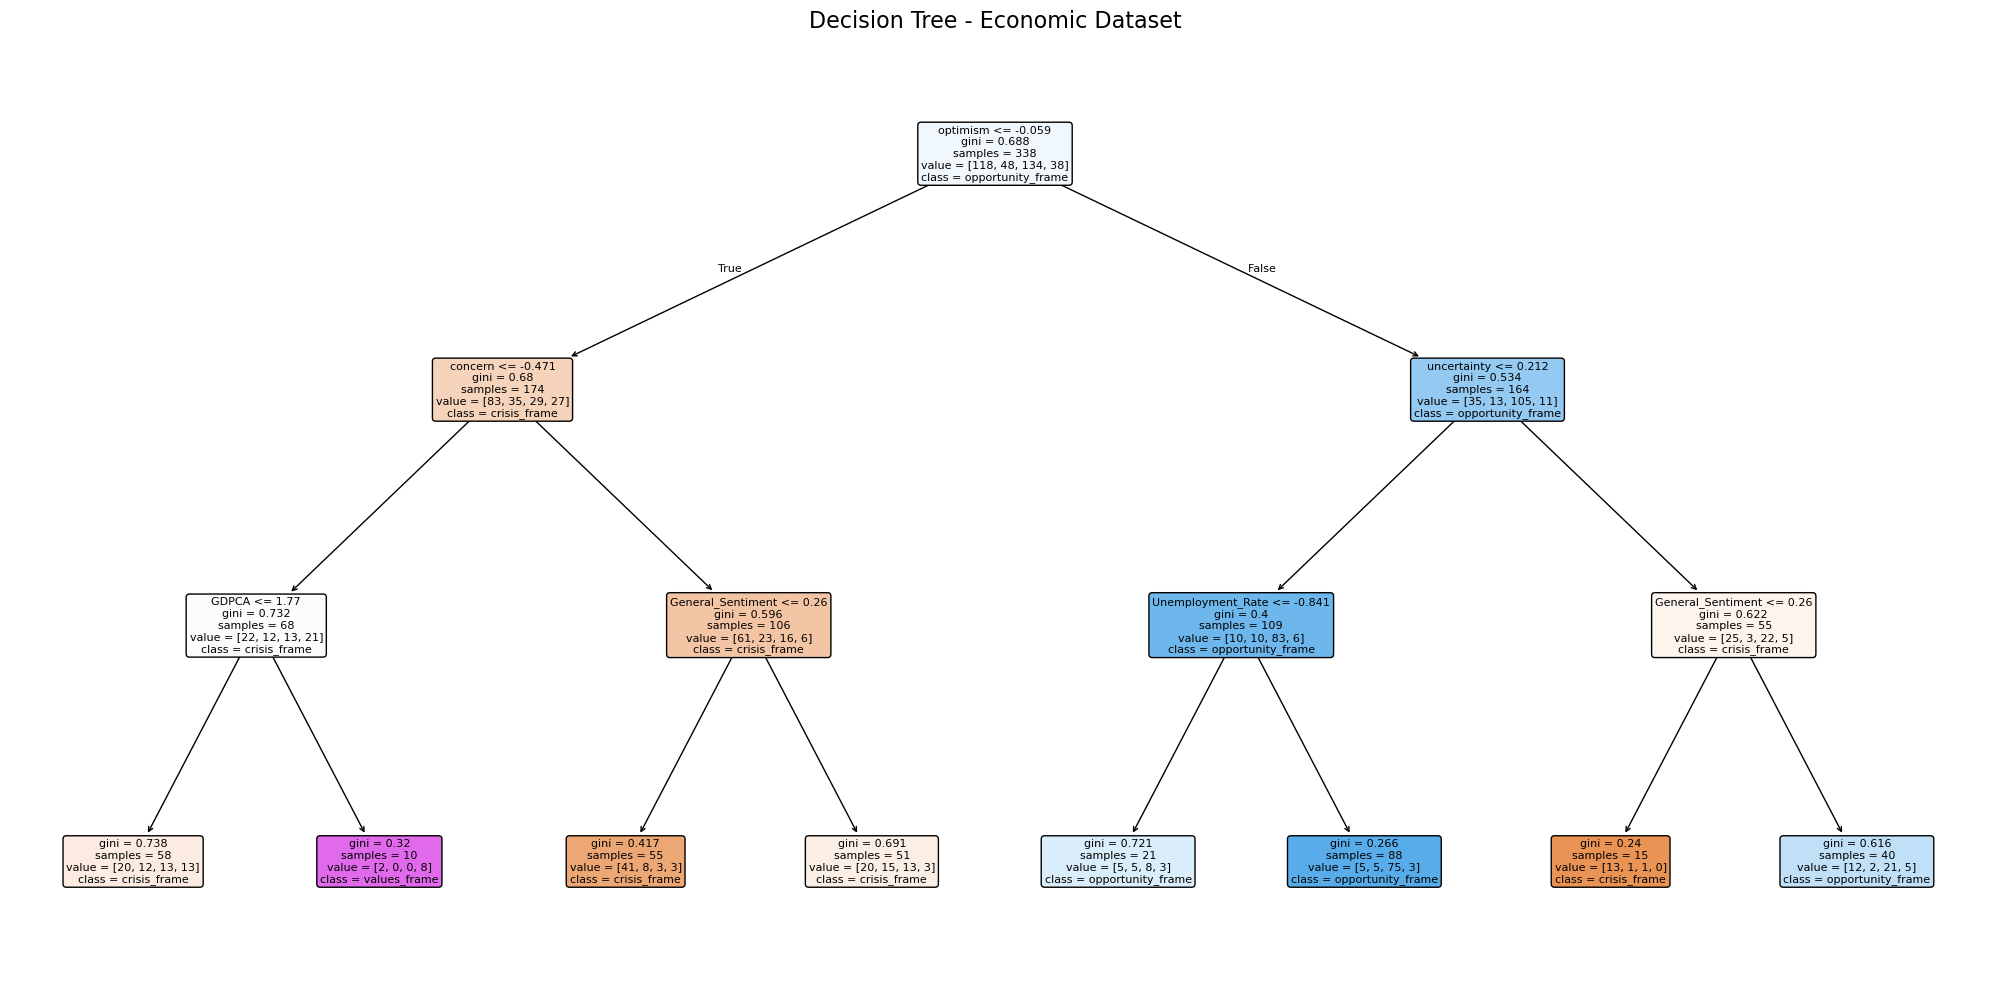

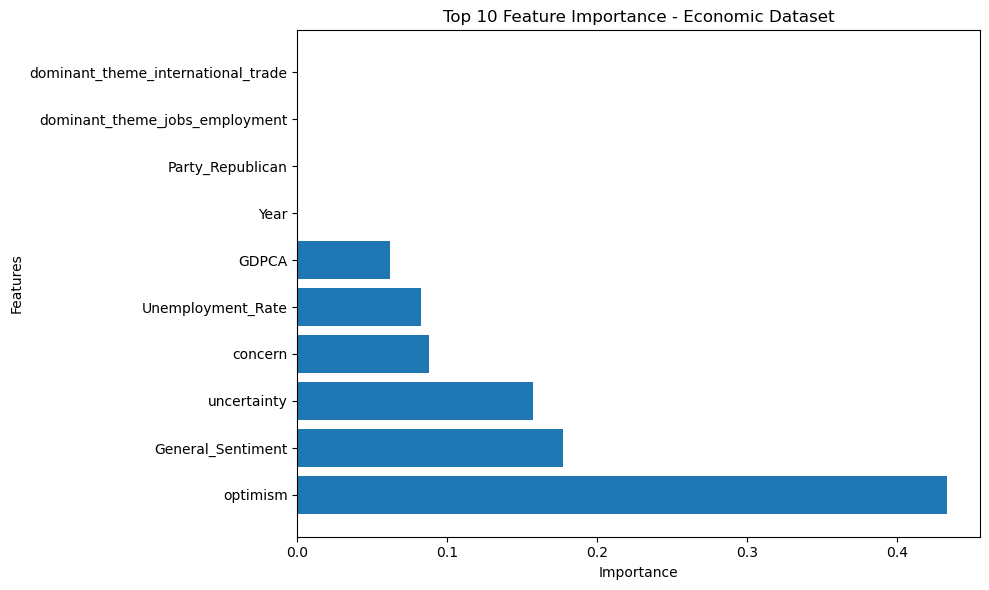

In [ ]:
# calculate and print some metrics for each model 
def print_global_metrics(y_true, y_pred):
    print("\nModel Performance Metrics:")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")

# plot the 10 most important features for each model 
def plot_feature_importance(model, features, title):
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_}).sort_values('importance', ascending=False)
    
    top_features = feature_importance.head(10)
    
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['feature'], top_features['importance'])
    plt.title(f"Top 10 Feature Importance - {title}")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

def build_historical_tree(df_historical, target_var='dominant_frame'):
    features = ['optimism', 'concern', 'confidence', 'uncertainty', 'Decade', 'Year', 'General_Sentiment', 'KMeans_Cluster', 'read_index']
    categorical_features = ['Party', 'Historical_Period', 'dominant_theme']
    
    model_df = df_historical.copy()
    model_df = model_df.dropna(subset=[f for f in features if f in model_df.columns] + [target_var])
    
    for cat_feature in categorical_features:
        if cat_feature in model_df.columns:
            model_df[cat_feature] = model_df[cat_feature].astype(str)
            dummies = pd.get_dummies(model_df[cat_feature], prefix=cat_feature, drop_first=True)
            model_df = pd.concat([model_df, dummies], axis=1)
            features.extend(dummies.columns.tolist())
    
    available_features = [f for f in features if f in model_df.columns]
    
    X = model_df[available_features]
    y = model_df[target_var]
    
    # handle unbalanced classes
    class_weights = compute_class_weight(class_weight='balanced', 
                                         classes=np.unique(y), 
                                         y=y)
    class_weight_dict = dict(zip(np.unique(y), class_weights))
    
    # standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    min_samples_per_class = y.value_counts().min()
    n_splits = min(5, min_samples_per_class)
    
    # Grid search with stratified cross-validation 
    param_grid = {
        'max_depth': [3, 4],
        'min_samples_leaf': [max(1, min_samples_per_class // 10)],
        'class_weight': [class_weight_dict, None]}
    
    grid_search = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid,
        cv=StratifiedKFold(n_splits=max(2, n_splits), shuffle=True, random_state=42),
        scoring='f1_weighted')
    
    grid_search.fit(X_scaled, y)
    
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_scaled)
    
    print_global_metrics(y, y_pred)
    
    plt.figure(figsize=(20, 10))
    plot_tree(best_model, 
              feature_names=available_features, 
              class_names=sorted(y.unique()),
              filled=True, 
              rounded=True,
              fontsize=8)
    plt.title("Decision Tree - Historical Dataset", fontsize=16)
    plt.tight_layout()
    plt.show()

    plot_feature_importance(best_model, available_features, "Historical Dataset")
    
    return best_model

def build_economic_tree(df_economic, target_var='dominant_frame'):
    numerical_features = ['optimism', 'concern', 'confidence', 'uncertainty', 'Decade', 'Year', 'General_Sentiment', 'KMeans_Cluster', 'read_index', 'UMCSENT_Scaled']
    economic_features = ['GDP_growth', 'GDPCA', 'Unemployment_Rate', 'Inflation_Rate', 'Economic_Health_Index']
    features = numerical_features + economic_features
    categorical_features = ['Party', 'Historical_Period', 'dominant_theme']

    model_df = df_economic.copy()
    model_df = model_df.dropna(subset=[f for f in features if f in model_df.columns] + [target_var])
    
    for cat_feature in categorical_features:
        if cat_feature in model_df.columns:
            model_df[cat_feature] = model_df[cat_feature].astype(str)
            dummies = pd.get_dummies(model_df[cat_feature], prefix=cat_feature, drop_first=True)
            model_df = pd.concat([model_df, dummies], axis=1)
            features.extend(dummies.columns.tolist())
    
    available_features = [f for f in features if f in model_df.columns]
    
    X = model_df[available_features]
    y = model_df[target_var]

    class_weights = compute_class_weight(class_weight='balanced', 
                                         classes=np.unique(y), 
                                         y=y)
    class_weight_dict = dict(zip(np.unique(y), class_weights))
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    min_samples_per_class = y.value_counts().min()
    n_splits = min(5, min_samples_per_class)

    param_grid = {
        'max_depth': [3, 4],
        'min_samples_leaf': [max(1, min_samples_per_class // 10)],
        'class_weight': [class_weight_dict, None]}
    
    grid_search = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid,
        cv=StratifiedKFold(n_splits=max(2, n_splits), shuffle=True, random_state=42),
        scoring='f1_weighted')
    
    grid_search.fit(X_scaled, y)
    
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_scaled)
    print_global_metrics(y, y_pred)
    
    plt.figure(figsize=(20, 10))
    plot_tree(best_model, 
              feature_names=available_features, 
              class_names=sorted(y.unique()),
              filled=True, 
              rounded=True,
              fontsize=8)
    plt.title("Decision Tree - Economic Dataset", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    plot_feature_importance(best_model, available_features, "Economic Dataset")
    
    return best_model

# Main execution
def main():
    historical_tree = build_historical_tree(df_historical)
    economic_tree = build_economic_tree(df_economic)

if __name__ == "__main__":
    main()

- The framing adopted in presidential speeches is minimally influenced by objective economic conditions, as the inclusion of economic indicators actually deceases the model's accuracy. Additionally, economic variables such as the unemployment rate and the per capita GDP appear among the most important features, but only after textual features, indicating their relatively low importance. This conclusion aligns perfectly with the persistent gap between Presidential Sentiment and the Economic Health Index observed earlier.
- Using only text data, we achieved a respectable accuracy, confirming that our text processing approach effectively captured meaningful patterns in presidential rhetoric. The emotional tone, dominant themes, and linguistic characteristics provided sufficient information to predict framing strategies.
- Regarding the trade-off between sample size and feature richness, the evidence suggests that sample size is preferable. The historical patterns captured in the larger dataset provide more valuable insights than the additional economic features in the restricted timeframe. 
- The fact that accuracies actually decreases when adding economic indicators might be due to the almost negligible negative correlation between the economic health index and the presidential speeches' sentiment. Given that there is basically no correlation between these economic indicators and the tone of presidential speeches, when adding these information the model is just capturing more noise which results in a worst accuracy. 

This reinforces our broader finding that presidential rhetoric follows its own internal logic rather than simply reflecting economic reality. Presidents appear to frame economic issues based on political considerations, communication strategies, and historical precedent, rather than in response to objective economic indicators.